# Stock Performance based on fundamental and technical indicators

#### Introduction: The purpose of this project is to determine if there is any combination of fundamental and technical indicators which will prove to be indicative of performance.  Fundamental data was purchased from simfin.com.  Daily stock data is a free download from eoddata.com.  Both sources would require upgrades to use in a real-time or near real-time environment.  Popular technical and fundamental technical indicators will be chose based on online research.  Histograms will be created to determine the shape of the data, and colinnearity will be measured to help determine variable selection. Finally, an NMF and jaccard similarity model are trained and assessed.

In [1]:
import pandas as pd
import numpy as np
import glob
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one

# K Nearest Neighbors classification algorithm

from sklearn.preprocessing import OneHotEncoder
from scipy.stats import linregress
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import math

from sklearn import svm, datasets
import simfin as sf
from simfin.names import *
from datetime import datetime
from datetime import timedelta
import tempfile
from sklearn.decomposition import NMF
from itertools import permutations


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=False, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 

# Initial Importation and Cleaning

In [ ]:
sf.set_api_key('###################')

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

# Load the annual Income Statements for all companies in the US.
# The data is automatically downloaded if you don't have it already.
income_data = sf.load_income(variant='quarterly', market='us')
company_data = sf.load_companies()
industry_data = sf.load_industries()

In [ ]:
income_data

In [ ]:
income_data2 = income_data[['Shares (Basic)','Net Income (Common)','Revenue']].copy()
income_data2['earnings_share'] = income_data2['Net Income (Common)']  / income_data2['Shares (Basic)'] 

In [ ]:
income_data3 = income_data2.reset_index()

In [ ]:
income_data3['annual_earnings'] = income_data3.groupby('Ticker')['Net Income (Common)'].rolling(window=4, min_periods=4).sum().reset_index()['Net Income (Common)']
income_data3['annual_revenue'] = income_data3.groupby('Ticker')['Revenue'].rolling(window=4, min_periods=4).sum().reset_index()['Revenue']

In [ ]:
income_data3['earnings_shift1'] = income_data3.groupby('Ticker')['Net Income (Common)'].shift(1)
income_data3['revenue_shift1'] = income_data3.groupby('Ticker')['annual_revenue'].shift(1)

In [ ]:
income_data3['earnings_growth'] = income_data3['annual_earnings'] / income_data3['earnings_shift1']
income_data3['revenue_growth'] = income_data3['annual_revenue'] / income_data3['revenue_shift1']

In [ ]:
company_data2 = company_data['IndustryId'].copy().to_frame()
company_data3 = company_data2.reset_index().merge(industry_data, how='inner', left_on='IndustryId', right_on='IndustryId')

In [ ]:
income_data4 = income_data3.reset_index().merge(company_data3, how='inner',left_on='Ticker', right_on = 'Ticker')

In [ ]:
income_data4['Report Date_Next'] = income_data4.groupby(['Ticker'])['Report Date'].shift(-1)

In [ ]:
income_data4['Report Date2'] = income_data4['Report Date'].dt.strftime('%Y%m%d')

In [ ]:
income_data4['Report Date_Next'] = income_data4['Report Date_Next'].fillna(pd.to_datetime(income_data4['Report Date2']) + timedelta(days=90)).dt.strftime('%Y%m%d')

In [ ]:
income_data4 = income_data4[['Ticker','Report Date', 'earnings_share','Industry','Sector','Report Date_Next','Report Date2','revenue_growth','earnings_growth']]

#### Nasdaq and NYSE data was pre downloaded to my computer after purchase

In [ ]:
directoryPath = "F:/Stocks/ST/NASDAQ_FINAL/"
nasdaq_working_data = pd.DataFrame()
for file_name in glob.glob(directoryPath+'*.txt'):
    x = pd.read_csv(file_name, low_memory=False)
    nasdaq_working_data = pd.concat([nasdaq_working_data,x],axis=0)

In [ ]:
nasdaq = nasdaq_working_data.rename(columns={"<ticker>": "ticker", "<date>": "date"
                          ,"<open>": "open"
                           ,"<high>": "high"
                           ,"<low>": "low"
                           ,"<close>": "close"
                           ,"<vol>": "volume"
                          })

In [ ]:
directoryPath = "F:/Stocks/ST/NYSE_FINAL/"
nyse_working_data = pd.DataFrame()
for file_name in glob.glob(directoryPath+'*.txt'):
    x = pd.read_csv(file_name, low_memory=False)
    nyse_working_data = pd.concat([nyse_working_data,x],axis=0)

In [ ]:
nyse = nyse_working_data.rename(columns={"<ticker>": "ticker", "<date>": "date"
                          ,"<open>": "open"
                           ,"<high>": "high"
                           ,"<low>": "low"
                           ,"<close>": "close"
                           ,"<vol>": "volume"
                          })

In [ ]:
final_data = pd.concat([nasdaq,nyse],axis=0)

In [ ]:
income_data4 = income_data4.rename(columns = {'Report Date_Next': 'report_date_next', 'Report Date2': 'report_date2'})

In [ ]:
final_data.to_csv('~/final_data.csv')

In [ ]:
income_data4.to_csv('~/income_data.csv')

In [4]:
income_data4 = pd.read_csv('~/income_data.csv')

In [3]:
final_data = pd.read_csv('~/final_data.csv')

#### Joining fundamentals with historical datasets

In [6]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

cond_join = '''select dF_left.*, df_right.* 
            from final_data as df_left
            join income_data4 as df_right
            on
                df_left.Ticker = df_right.Ticker
                and df_left.date > df_right.report_date2
                and df_left.date <= df_right.report_date_next
            '''


final_data_with_fund_temp = pysqldf(cond_join)

In [7]:
final_data_with_fund_temp.to_csv('~/final_data_with_fund_temp.csv')

In [3]:
final_data_with_fund_temp = pd.read_csv('~/final_data_with_fund_temp.csv')

In [4]:
final_data = final_data_with_fund_temp

In [5]:
final_data['earnings_days'] = pd.to_datetime(final_data['date'], format='%Y%m%d') - pd.to_datetime(final_data['report_date2'], format='%Y%m%d')

In [6]:
final_data['earnings_1wk'] = np.where(final_data['earnings_days'] < timedelta(days=7),1,0)
final_data['earnings_2wk'] = np.where(final_data['earnings_days'] < timedelta(days=14),1,0)
final_data['earnings_4wk'] = np.where(final_data['earnings_days'] < timedelta(days=28),1,0)
final_data['earnings_8wk'] = np.where(final_data['earnings_days'] < timedelta(days=56),1,0)

## Removing Tickers with High and Low Closing Prices

In [7]:
final_low = final_data.loc[final_data['close'] < 10]
low_ticks = final_low['ticker'].unique()
final_data2 = final_data[~final_data['ticker'].isin(low_ticks)]

In [8]:
final_high = final_data2.loc[final_data2['close'] > 300]
high_ticks = final_high['ticker'].unique()
final_data3 = final_data2[~final_data2['ticker'].isin(high_ticks)].copy()

## Removing Low Volume Tickers

In [9]:
final_data4 = final_data3.loc[final_data3['volume'] > 0].copy()

In [10]:
final_data4['date2'] = pd.to_datetime(final_data4['date'], format='%Y%m%d')

In [11]:
final_data4['month'] = final_data4['date2'].dt.month
final_data4['year'] = final_data4['date2'].dt.year

In [12]:
volume_summary = final_data4.groupby(['ticker','year','month']).mean('volume').reset_index()

In [13]:
low_volume_tickers = volume_summary.loc[volume_summary['volume'] < 50000]['ticker'].unique()

In [14]:
len(low_volume_tickers)

182

In [15]:
final_data5 = final_data4[~final_data4['ticker'].isin(low_volume_tickers)].copy()

In [16]:
final_data5 = final_data5.drop(columns = ['month','year','date'])

In [17]:
len(final_data5)

1661874

In [18]:
len(final_data5['ticker'].unique())

1110

# Adding Technical Indicator Precursors

In [19]:
final_data_precursor = final_data5.set_index(['ticker', 'date2']).copy()

## Adding Volatility

In [20]:
final_data_precursor['close-1'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(1)
final_data_precursor['pct_chg'] = (final_data_precursor['close'] / final_data_precursor['close-1']) - 1

final_data_precursor['volatility'] = final_data_precursor['pct_chg'].groupby(level=["ticker"]).rolling(min_periods=30, window=30).std().droplevel(0,axis = 0)*(252**0.5)
final_data_precursor = final_data_precursor.drop(columns = ['close-1','pct_chg'])

In [21]:
final_data_precursor

Unnamed: 0.2  Unnamed: 0    open     high      low   close  \
ticker date2                                                                    
ADI    2014-05-01             0          23   51.38   51.530   50.760   50.82   
AMAT   2014-05-01             2          53   19.13   19.290   18.860   18.88   
AVAV   2014-05-01             3         111   33.65   34.240   33.060   33.84   
CAKE   2014-05-01             4         177   45.14   45.640   44.780   45.59   
CASY   2014-05-01             5         188   68.38   68.740   67.340   68.41   
...                         ...         ...     ...      ...      ...     ...   
YUM    2023-10-17       4680500        2967  119.04  119.978  118.865  119.44   
YUMC   2023-10-17       4680501        2968   52.66   53.190   52.600   52.90   
ZBH    2023-10-17       4680502        2969  104.37  108.020  104.090  106.59   
ZIP    2023-10-17       4680504        2975   11.06   11.300   10.990   11.00   
ZTS    2023-10-17       4680505        2978  172.87  174.430  171.381  174.26   

                     volume  Unnamed: 0.1 Ticker Report Date  ...  \
ticker date2                                                  ...   
ADI    2014-05-01   1529000          1900    ADI  2014-04-30  ...   
AMAT   2014-05-01  17221300          5036   AMAT  2014-04-30  ...   
AVAV   2014-05-01    311000          9910   AVAV  2014-04-30  ...   
CAKE   2014-05-01   1002900         16158   CAKE  2014-04-30  ...   
CASY   2014-05-01    190300         16632   CASY  2014-04-30  ...   
...                     ...           ...    ...         ...  ...   
YUM    2023-10-17   1267400        103252    YUM  2023-09-30  ...   
YUMC   2023-10-17   1048500        103277   YUMC  2023-09-30  ...   
ZBH    2023-10-17   1455000        103402    ZBH  2023-09-30  ...   
ZIP    2023-10-17    847600        103633    ZIP  2023-09-30  ...   
ZTS    2023-10-17   1716200        103851    ZTS  2023-09-30  ...   

                   report_date_next report_date2 revenue_growth  \
ticker date2                                                      
ADI    2014-05-01          20140731     20140430            NaN   
AMAT   2014-05-01          20140731     20140430            NaN   
AVAV   2014-05-01          20140731     20140430            NaN   
CAKE   2014-05-01          20140731     20140430            NaN   
CASY   2014-05-01          20140731     20140430            NaN   
...                             ...          ...            ...   
YUM    2023-10-17          20231231     20230930       1.009727   
YUMC   2023-10-17          20231231     20230930       1.022138   
ZBH    2023-10-17          20231231     20230930       1.011646   
ZIP    2023-10-17          20231231     20230930       0.909883   
ZTS    2023-10-17          20231231     20230930       1.018122   

                   earnings_growth  earnings_days  earnings_1wk  earnings_2wk  \
ticker date2                                                                    
ADI    2014-05-01              NaN         1 days             1             1   
AMAT   2014-05-01              NaN         1 days             1             1   
AVAV   2014-05-01              NaN         1 days             1             1   
CAKE   2014-05-01              NaN         1 days             1             1   
CASY   2014-05-01              NaN         1 days             1             1   
...                            ...            ...           ...           ...   
YUM    2023-10-17         3.590909        17 days             0             0   
YUMC   2023-10-17         3.974619        17 days             0             0   
ZBH    2023-10-17         2.262154        17 days             0             0   
ZIP    2023-10-17         4.372601        17 days             0             0   
ZTS    2023-10-17         3.397914        17 days             0             0   

                  earnings_4wk  earnings_8wk  volatility  
ticker date2                                              
ADI    2014-05-01      

### Money Flow Index

In [22]:
final_data_precursor = final_data_precursor.sort_index(ascending=True)
final_data_precursor['typical'] = (final_data_precursor['close'] + final_data_precursor['high'] + final_data_precursor['low']) / 3
final_data_precursor['money_flow'] = final_data_precursor['typical'] *  final_data_precursor['volume']
shifted = final_data_precursor.groupby(level=["ticker"]).shift(1)['money_flow'].to_frame()
final_data_precursor = final_data_precursor.join(shifted, rsuffix='_lag')
final_data_precursor['net_money_flow'] = final_data_precursor['money_flow'] - final_data_precursor['money_flow_lag']
final_data_precursor['pos_money_flow'] = final_data_precursor[final_data_precursor['net_money_flow'] > 0]['net_money_flow']
final_data_precursor['pos_money_flow'].fillna(0, inplace=True)
final_data_precursor['neg_money_flow'] = -final_data_precursor[final_data_precursor['net_money_flow'] < 0]['net_money_flow']
final_data_precursor['neg_money_flow'].fillna(0, inplace=True)
final_data_precursor['pos_money_flow30'] = final_data_precursor['pos_money_flow'].groupby(level=["ticker"]).rolling(min_periods=30, window=30).sum().droplevel(0,axis = 0)
final_data_precursor['neg_money_flow30'] = final_data_precursor['neg_money_flow'].groupby(level=["ticker"]).rolling(min_periods=30, window=30).sum().droplevel(0,axis = 0)
final_data_precursor['money_ratio'] = final_data_precursor['pos_money_flow30'] / final_data_precursor['neg_money_flow30']
final_data_precursor['money_flow_index'] =    100 - (100/(1+ final_data_precursor['money_ratio']))

final_data_precursor = final_data_precursor.drop(columns = ['net_money_flow','money_flow','money_flow_lag',
                                                            'pos_money_flow','neg_money_flow','pos_money_flow30',
                                                            'neg_money_flow30','money_ratio','typical'])


### Exponential Moving Averages

In [23]:
final_data_precursor['ema_12'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=12,min_periods=12,adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['ema_26'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=26,min_periods=26,adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['ema_40'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=40,min_periods=40,adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['ema_100'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=100,min_periods=100, adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['ema_200'] = final_data_precursor['close'].groupby(level=["ticker"]).ewm(span=200,min_periods=200, adjust=False).mean().droplevel(0,axis = 0)

final_data_precursor['ema_12_Dist'] = (final_data_precursor['ema_12'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['ema_26_Dist'] = (final_data_precursor['ema_26'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['ema_40_Dist'] = (final_data_precursor['ema_40'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['ema_100_Dist'] = (final_data_precursor['ema_100'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['ema_200_Dist'] = (final_data_precursor['ema_200'] - final_data_precursor['close']) / final_data_precursor['close']


### KST Indicator

####      ROC

In [24]:
final_data_precursor['Close-10'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(10)
final_data_precursor['Close-15'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(15)
final_data_precursor['Close-20'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(20)
final_data_precursor['Close-30'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(30)

final_data_precursor['ROC10'] = (final_data_precursor['close'] - final_data_precursor['Close-10'])/ final_data_precursor['Close-10'] * 100
final_data_precursor['ROC15'] = (final_data_precursor['close'] - final_data_precursor['Close-15'])/ final_data_precursor['Close-15'] * 100
final_data_precursor['ROC20'] = (final_data_precursor['close'] - final_data_precursor['Close-20'])/ final_data_precursor['Close-20'] * 100
final_data_precursor['ROC30'] = (final_data_precursor['close'] - final_data_precursor['Close-30'])/ final_data_precursor['Close-30'] * 100

In [25]:
final_data_precursor['ROC10MA'] = final_data_precursor['ROC10'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).mean().droplevel(0,axis = 0)
final_data_precursor['ROC15MA'] = final_data_precursor['ROC15'].groupby(level=["ticker"]).rolling(min_periods=15, window=15).mean().droplevel(0,axis = 0)
final_data_precursor['ROC20MA'] = final_data_precursor['ROC20'].groupby(level=["ticker"]).rolling(min_periods=20, window=20).mean().droplevel(0,axis = 0)
final_data_precursor['ROC30MA'] = final_data_precursor['ROC30'].groupby(level=["ticker"]).rolling(min_periods=30, window=30).mean().droplevel(0,axis = 0)

In [26]:
final_data_precursor['KST'] = (final_data_precursor['ROC10MA'] + final_data_precursor['ROC15MA']*2 
                               + final_data_precursor['ROC20MA']*3 + final_data_precursor['ROC30MA']*4)/10
final_data_precursor['KST-1'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(1)
final_data_precursor['KST-2'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(2)
final_data_precursor['KST-3'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(3)
final_data_precursor['KST-4'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(4)
final_data_precursor['KST-5'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(5)
final_data_precursor['KST-6'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(6)
final_data_precursor['KST-7'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(7)
final_data_precursor['KST-8'] = final_data_precursor['KST'].groupby(level=["ticker"]).shift(8)

In [27]:
final_data_precursor['KST_Signal'] = (final_data_precursor['KST'] + final_data_precursor['KST-1'] + 
                                      final_data_precursor['KST-2'] + final_data_precursor['KST-3'] + 
                                      final_data_precursor['KST-4'] + final_data_precursor['KST-5'] +
                                      final_data_precursor['KST-6'] + final_data_precursor['KST-7'] +
                                      final_data_precursor['KST-8'])/9


In [28]:
final_data_precursor['KST2'] = final_data_precursor['KST'] / final_data_precursor['close']
final_data_precursor['KST_Signal2'] = final_data_precursor['KST_Signal'] / final_data_precursor['close']

In [29]:
final_data_precursor = final_data_precursor.drop(columns = ['ROC10','ROC15','ROC20','ROC30',
                                                            'ROC10MA','ROC15MA','ROC20MA','ROC30MA',
                                                            'KST-1','KST-2','KST-3',
                                                            'KST-4','KST-5','KST-6',
                                                            'KST-7','KST-8'])

## Trendlines(Excluded for the time being)

## Bollinger Bands

In [30]:
final_data_precursor['sma_20'] = final_data_precursor['close'].groupby(level=["ticker"]).rolling(min_periods=20, window=20).mean().droplevel(0,axis = 0)
final_data_precursor['std_20'] = final_data_precursor['close'].groupby(level=["ticker"]).rolling(min_periods=20, window=20).std().droplevel(0,axis = 0)
final_data_precursor['Boll_Upper'] = final_data_precursor['sma_20'] + (final_data_precursor['std_20'] * 2)
final_data_precursor['Boll_Mid'] = final_data_precursor['sma_20']
final_data_precursor['Boll_Lower'] = final_data_precursor['sma_20'] - (final_data_precursor['std_20'] * 2)

final_data_precursor['Boll_Upper_Dist'] = ((final_data_precursor['Boll_Upper'] / final_data_precursor['close']) - 1) / final_data_precursor['volatility']
final_data_precursor['Boll_Mid_Dist'] = ((final_data_precursor['Boll_Mid'] / final_data_precursor['close']) - 1) / final_data_precursor['volatility']
final_data_precursor['Boll_Lower_Dist'] = ((final_data_precursor['Boll_Lower'] /final_data_precursor['close']) - 1) / final_data_precursor['volatility']

## Relative Strength Index (RSI): 

In [31]:
final_data_precursor['delta']  = final_data_precursor['close'].groupby(level=["ticker"]).diff() 
final_data_precursor['gain']  = final_data_precursor['delta'].where(final_data_precursor['delta'] > 0, 0) 
final_data_precursor['loss']  = -final_data_precursor['delta'].where(final_data_precursor['delta'] < 0, 0) 
 
# Calculate average gain and loss 
final_data_precursor['average_gain']  = final_data_precursor['gain'].groupby(level=["ticker"]).rolling(window=14).mean().droplevel(0,axis = 0) 
final_data_precursor['average_loss']  = final_data_precursor['loss'].groupby(level=["ticker"]).rolling(window=14).mean().droplevel(0,axis = 0)
 
# Calculate RSI 
final_data_precursor['rs']  = final_data_precursor['average_gain'] / final_data_precursor['average_loss'].abs() 
final_data_precursor['RSI'] = 100 - (100 / (1 + final_data_precursor['rs'])) 

final_data_precursor = final_data_precursor.drop(columns = ['delta','gain','average_gain','average_loss','loss','rs'])

## MACD 

In [32]:
final_data_precursor['MACD_Line'] = final_data_precursor['ema_12'] - final_data_precursor['ema_26']
final_data_precursor['MACD_Signal'] = final_data_precursor['MACD_Line'].groupby(level=["ticker"]).ewm(span=9,min_periods=9,adjust=False).mean().droplevel(0,axis = 0)
final_data_precursor['MACD_Histogram'] = final_data_precursor['MACD_Line'] - final_data_precursor['MACD_Signal']

final_data_precursor['MACD_Line2'] = final_data_precursor['MACD_Line'] / final_data_precursor['close']
final_data_precursor['MACD_Signal2'] = final_data_precursor['MACD_Signal'] / final_data_precursor['close']
final_data_precursor['MACD_Histogram2'] = final_data_precursor['MACD_Histogram'] / final_data_precursor['close']

## Stochastic Oscillator

In [33]:
final_data_precursor['Lowest_Low'] = final_data_precursor['low'].groupby(level=["ticker"]).rolling(min_periods=14, window=14).min().droplevel(0,axis = 0)
final_data_precursor['Highest_High'] = final_data_precursor['high'].groupby(level=["ticker"]).rolling(min_periods=14, window=14).max().droplevel(0,axis = 0)
final_data_precursor['SO_K'] = (final_data_precursor['close'] - final_data_precursor['Lowest_Low'])  / (final_data_precursor['Highest_High'] - final_data_precursor['Lowest_Low']) * 100
final_data_precursor['SO_D'] = final_data_precursor['SO_K'].groupby(level=["ticker"]).rolling(min_periods=3, window=3).mean().droplevel(0,axis = 0)

## Average True Range (ATR)

In [34]:
final_data_precursor['Close_1'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(1)
final_data_precursor['ATR_A'] = abs(final_data_precursor['high']-final_data_precursor['low'])
final_data_precursor['ATR_B'] = abs(final_data_precursor['high']-final_data_precursor['Close_1'])
final_data_precursor['ATR_C']  = abs(final_data_precursor['low']-final_data_precursor['Close_1'])
final_data_precursor['TR'] = final_data_precursor[["ATR_A", "ATR_B","ATR_C"]].max(axis=1)  
final_data_precursor['ATR'] = final_data_precursor['TR'].groupby(level=["ticker"]).rolling(min_periods=14, window=14).mean().droplevel(0,axis = 0)
final_data_precursor['ATR2'] = final_data_precursor['ATR'] / final_data_precursor['close']


final_data_precursor = final_data_precursor.drop(columns = ['Close_1','ATR_A','ATR_B','ATR_C','TR'])

## Fibonacci Levels

In [35]:
final_data_precursor['fibo0'] = final_data_precursor['close'].groupby(level=["ticker"]).rolling(min_periods=90, window=90).min().droplevel(0,axis = 0)
final_data_precursor['fibo100'] = final_data_precursor['close'].groupby(level=["ticker"]).rolling(min_periods=90, window=90).max().droplevel(0,axis = 0)
final_data_precursor['fibo25'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .25) + final_data_precursor['fibo0']
final_data_precursor['fibo38'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .38) + final_data_precursor['fibo0']
final_data_precursor['fibo50'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .50) + final_data_precursor['fibo0']
final_data_precursor['fibo618'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .618) + final_data_precursor['fibo0']
final_data_precursor['fibo786'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .786) + final_data_precursor['fibo0']
final_data_precursor['fibo886'] = ((final_data_precursor['fibo100'] - final_data_precursor['fibo0']) * .886) + final_data_precursor['fibo0']


final_data_precursor['fibo0_Dist'] = (final_data_precursor['fibo0'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo25_Dist'] = (final_data_precursor['fibo25'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo50_Dist'] = (final_data_precursor['fibo50'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo618_Dist'] = (final_data_precursor['fibo618'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo786_Dist'] = (final_data_precursor['fibo786'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo886_Dist'] = (final_data_precursor['fibo886'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['fibo100_Dist'] = (final_data_precursor['fibo100'] - final_data_precursor['close']) / final_data_precursor['close']

## Ichimoku Cloud

In [36]:
final_data_precursor['IC_9_High'] = final_data_precursor['high'].groupby(level=["ticker"]).rolling(min_periods=9, window=9).max().droplevel(0,axis = 0)
final_data_precursor['IC_9_Low'] = final_data_precursor['low'].groupby(level=["ticker"]).rolling(min_periods=9, window=9).min().droplevel(0,axis = 0)
final_data_precursor['IC_26_High'] = final_data_precursor['high'].groupby(level=["ticker"]).rolling(min_periods=26, window=26).max().droplevel(0,axis = 0)
final_data_precursor['IC_26_Low'] = final_data_precursor['low'].groupby(level=["ticker"]).rolling(min_periods=26, window=26).min().droplevel(0,axis = 0)
final_data_precursor['IC_52_High'] = final_data_precursor['high'].groupby(level=["ticker"]).rolling(min_periods=52, window=52).max().droplevel(0,axis = 0)
final_data_precursor['IC_52_Low'] = final_data_precursor['low'].groupby(level=["ticker"]).rolling(min_periods=52, window=52).min().droplevel(0,axis = 0)

final_data_precursor['IC_CL'] = (final_data_precursor['IC_9_High'] + final_data_precursor['IC_9_Low']) / 2
final_data_precursor['IC_BL'] = (final_data_precursor['IC_26_High'] + final_data_precursor['IC_26_Low']) / 2

final_data_precursor['LS_A'] = (final_data_precursor['IC_CL'] + final_data_precursor['IC_BL']) / 2
final_data_precursor['LS_B'] = (final_data_precursor['IC_52_High'] + final_data_precursor['IC_52_Low']) / 2

final_data_precursor['Close_26'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(26)

final_data_precursor = final_data_precursor.drop(columns = ['IC_9_High','IC_9_Low','IC_26_High','IC_26_Low','IC_52_High','IC_52_Low'])


final_data_precursor['IC_CL2'] = (final_data_precursor['IC_CL']  - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['IC_BL2'] = (final_data_precursor['IC_BL'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['LS_A2'] = (final_data_precursor['LS_A'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['LS_B2'] = (final_data_precursor['LS_B'] - final_data_precursor['close']) / final_data_precursor['close']
final_data_precursor['Close_26_2'] =  (final_data_precursor['Close_26'] - final_data_precursor['close']) / final_data_precursor['close']

## On-Balance Volume (OBV)

In [37]:
final_data_precursor['Close_1'] = final_data_precursor['close'].groupby(level=["ticker"]).shift(1)
final_data_precursor['OBV_A'] = np.where(final_data_precursor['close']  > final_data_precursor['Close_1'],final_data_precursor['volume'],0)
final_data_precursor['OBV_A'] = np.where(final_data_precursor['close']  < final_data_precursor['Close_1'],-final_data_precursor['volume'],final_data_precursor['OBV_A'])
final_data_precursor['OBV_A'] = np.where(final_data_precursor['close']  == final_data_precursor['Close_1'],0,final_data_precursor['OBV_A'])
final_data_precursor['OBV'] = final_data_precursor['OBV_A'].groupby(level=["ticker"]).rolling(min_periods=26, window=26).sum().droplevel(0,axis = 0)
final_data_precursor = final_data_precursor.drop(columns = ['Close_1','OBV_A'])

final_data_precursor['vol26_avg'] = final_data_precursor['volume'].groupby(level=["ticker"]).rolling(min_periods=26, window=26).mean().droplevel(0,axis = 0)
final_data_precursor['OBV2'] = final_data_precursor['OBV'] / final_data_precursor['vol26_avg']

In [38]:
final_data_precursor

Unnamed: 0.2  Unnamed: 0     open     high      low  \
ticker date2                                                             
A      2014-05-01       2549543           0  38.5837  39.2489  38.3834   
       2014-05-02       2549599           0  38.9843  39.3348  38.6910   
       2014-05-05       2549655           0  38.8484  39.5851  38.5479   
       2014-05-06       2549711           0  39.3991  39.6638  38.9557   
       2014-05-07       2549767           0  39.4349  39.4349  38.8197   
...                         ...         ...      ...      ...      ...   
ZUMZ   2023-10-12       2542953        4522  17.2200  17.2200  16.3100   
       2023-10-13       2544607        4464  16.4800  16.4800  15.6700   
       2023-10-16       2546266        4501  15.9500  16.9600  15.9500   
       2023-10-17       2547923        4484  16.8600  17.7600  16.6550   
       2023-10-18       2549541        3933  17.5200  17.5800  17.2400   

                     close   volume  Unnamed: 0.1 Ticker Report Date  ...  \
ticker date2                                                          ...   
A      2014-05-01  38.9628  1472400             0      A  2014-04-30  ...   
       2014-05-02  39.0129  2080900             0      A  2014-04-30  ...   
       2014-05-05  39.5780  2087200             0      A  2014-04-30  ...   
       2014-05-06  39.3491  2224200             0      A  2014-04-30  ...   
       2014-05-07  39.3634  2219200             0      A  2014-04-30  ...   
...                    ...      ...           ...    ...         ...  ...   
ZUMZ   2023-10-12  16.5000   256700        103890   ZUMZ  2023-07-31  ...   
       2023-10-13  15.8100   409400        103890   ZUMZ  2023-07-31  ...   
       2023-10-16  16.8600   266900        103890   ZUMZ  2023-07-31  ...   
       2023-10-17  17.6900   298400        103890   ZUMZ  2023-07-31  ...   
       2023-10-18  17.2400    45812        103890   ZUMZ  2023-07-31  ...   

                     LS_B Close_26    IC_CL2    IC_BL2     LS_A2     LS_B2  \
ticker date2                                                                 
A      2014-05-01     NaN      NaN       NaN       NaN       NaN       NaN   
       2014-05-02     NaN      NaN       NaN       NaN       NaN       NaN   
       2014-05-05     NaN      NaN       NaN       NaN       NaN       NaN   
       2014-05-06     NaN      NaN       NaN       NaN       NaN       NaN   
       2014-05-07     NaN      NaN       NaN       NaN       NaN       NaN   
...                   ...      ...       ...       ...       ...       ...   
ZUMZ   2023-10-12  17.690   18.710  0.033030  0.051212  0.042121  0.072121   
       2023-10-13  17.525   18.660  0.051233  0.068020  0.059627  0.108476   
       2023-10-16  17.525   16.755 -0.014235  0.000593 -0.006821  0.039442   
       2023-10-17  17.525   17.450 -0.055116 -0.046354 -0.050735 -0.009327   
       2023-10-18  17.525   16.475 -0.030452 -0.021462 -0.025957  0.016531   

                   Close_26_2        OBV      vol26_avg      OBV2  
ticker date2                                                       
A      2014-05-01         NaN        NaN            NaN       NaN  
       2014-05-02         NaN        NaN            NaN       NaN  
       2014-05-05         NaN        NaN            NaN       NaN  
       2014-05-06         NaN        NaN            NaN       NaN  
       2014-05-07         NaN        NaN            NaN       NaN  
...                       ...        ...            ...       ...  
ZUMZ   2023-10-12    0.133939 -2581000.0  391207.692308 -6.597519  
       2023-10-13    0.180266 -2213200.0  377061.538462 -5.869599  
       2023-10-16   -0.006228  -606100.0  335780.769231 -1.805047  
       2023-10-17   -0.013567  -922600.0  323607.692308 -2.850983  
       2023-10-18   -0.044374  -411412.0  303946.615385 -1.353567  

[1661874 rows x 91 columns]

## Fundamentals

In [39]:
final_data_precursor['price_earnings'] = final_data_precursor['close'] / final_data_precursor['earnings_share']
fund_summary1 = final_data_precursor.reset_index()[['Industry','Sector','date2','close','price_earnings']].copy()

fund_summary2 = fund_summary1.groupby(['Industry','Sector','date2']).mean().reset_index()
fund_summary2 = fund_summary2.rename(columns={'price_earnings': 'industry_price_earnings'})
fund_summary2 = fund_summary2.drop(columns='close')

In [40]:
fund_summary3 = final_data_precursor.reset_index().merge(fund_summary2, how='inner', left_on=['Industry','Sector','date2'], right_on=['Industry','Sector','date2'])

In [41]:

#fund_summary2['price_earnings'] = fund_summary3['earnings_share']/fund_summary3['close']
fund_summary3['pe_vs_ind'] = fund_summary3['price_earnings']/fund_summary3['industry_price_earnings']
final_data_precursor = fund_summary3

## Dependent Variable Selection

In [42]:
final_data_precursor['2_wk_close'] = final_data_precursor[['close','ticker']].groupby('ticker').shift(-10)
final_data_precursor['2_wk_close_pct'] = final_data_precursor['2_wk_close'] / final_data_precursor['close']
final_data_precursor['3_Pct_Up_Flg'] = np.where(final_data_precursor['2_wk_close_pct'] > 1.03,1,0)

In [56]:
final_data_precursor = final_data_precursor.set_index(['ticker','date2'])

In [57]:
final_data_precursor.columns

Index(['Unnamed: 0.2', 'Unnamed: 0', 'open', 'high', 'low', 'close', 'volume',
       'Unnamed: 0.1', 'Ticker', 'Report Date',
       ...
       'SO_D_scaled', 'KST_scaled', 'KST_Signal_scaled', 'earnings_decile',
       'revenue_decile', 'pe_vs_ind_decile', 'ema_12v26', 'ema_26v40',
       'ema_40v100', 'ema_100v200'],
      dtype='object', length=136)

## Histogram of all variables

In [58]:
hist_table = final_data_precursor[['2_wk_close_pct','ATR2','MACD_Line2','MACD_Signal2','MACD_Histogram2'
                                  ,'Boll_Upper_Dist','Boll_Mid_Dist','Boll_Lower_Dist'
                                  ,'ema_12_Dist','ema_26_Dist','ema_40_Dist','ema_100_Dist','ema_200_Dist'
                                  ,'money_flow_index','fibo0_Dist','fibo25_Dist','fibo50_Dist'
                                  ,'fibo618_Dist','fibo786_Dist','fibo886_Dist'
                                  ,'fibo100_Dist','IC_CL2','IC_BL2','LS_A2','LS_B2'
                                  ,'Close_26_2','OBV2','RSI','SO_K','SO_D','KST2','KST_Signal2','pe_vs_ind'
                                   ,'revenue_growth', 'earnings_growth','Industry','Sector' ]].copy()

hist_table.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\Eric\AppData\Local\Temp\ipykernel_23236\1584262666.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist_table.hist(ax = ax)


array([[<Axes: title={'center': '2_wk_close_pct'}>,
        <Axes: title={'center': 'ATR2'}>,
        <Axes: title={'center': 'MACD_Line2'}>,
        <Axes: title={'center': 'MACD_Signal2'}>,
        <Axes: title={'center': 'MACD_Histogram2'}>,
        <Axes: title={'center': 'Boll_Upper_Dist'}>],
       [<Axes: title={'center': 'Boll_Mid_Dist'}>,
        <Axes: title={'center': 'Boll_Lower_Dist'}>,
        <Axes: title={'center': 'ema_12_Dist'}>,
        <Axes: title={'center': 'ema_26_Dist'}>,
        <Axes: title={'center': 'ema_40_Dist'}>,
        <Axes: title={'center': 'ema_100_Dist'}>],
       [<Axes: title={'center': 'ema_200_Dist'}>,
        <Axes: title={'center': 'money_flow_index'}>,
        <Axes: title={'center': 'fibo0_Dist'}>,
        <Axes: title={'center': 'fibo25_Dist'}>,
        <Axes: title={'center': 'fibo50_Dist'}>,
        <Axes: title={'center': 'fibo618_Dist'}>],
       [<Axes: title={'center': 'fibo786_Dist'}>,
        <Axes: title={'center': 'fibo886_Dist'}>

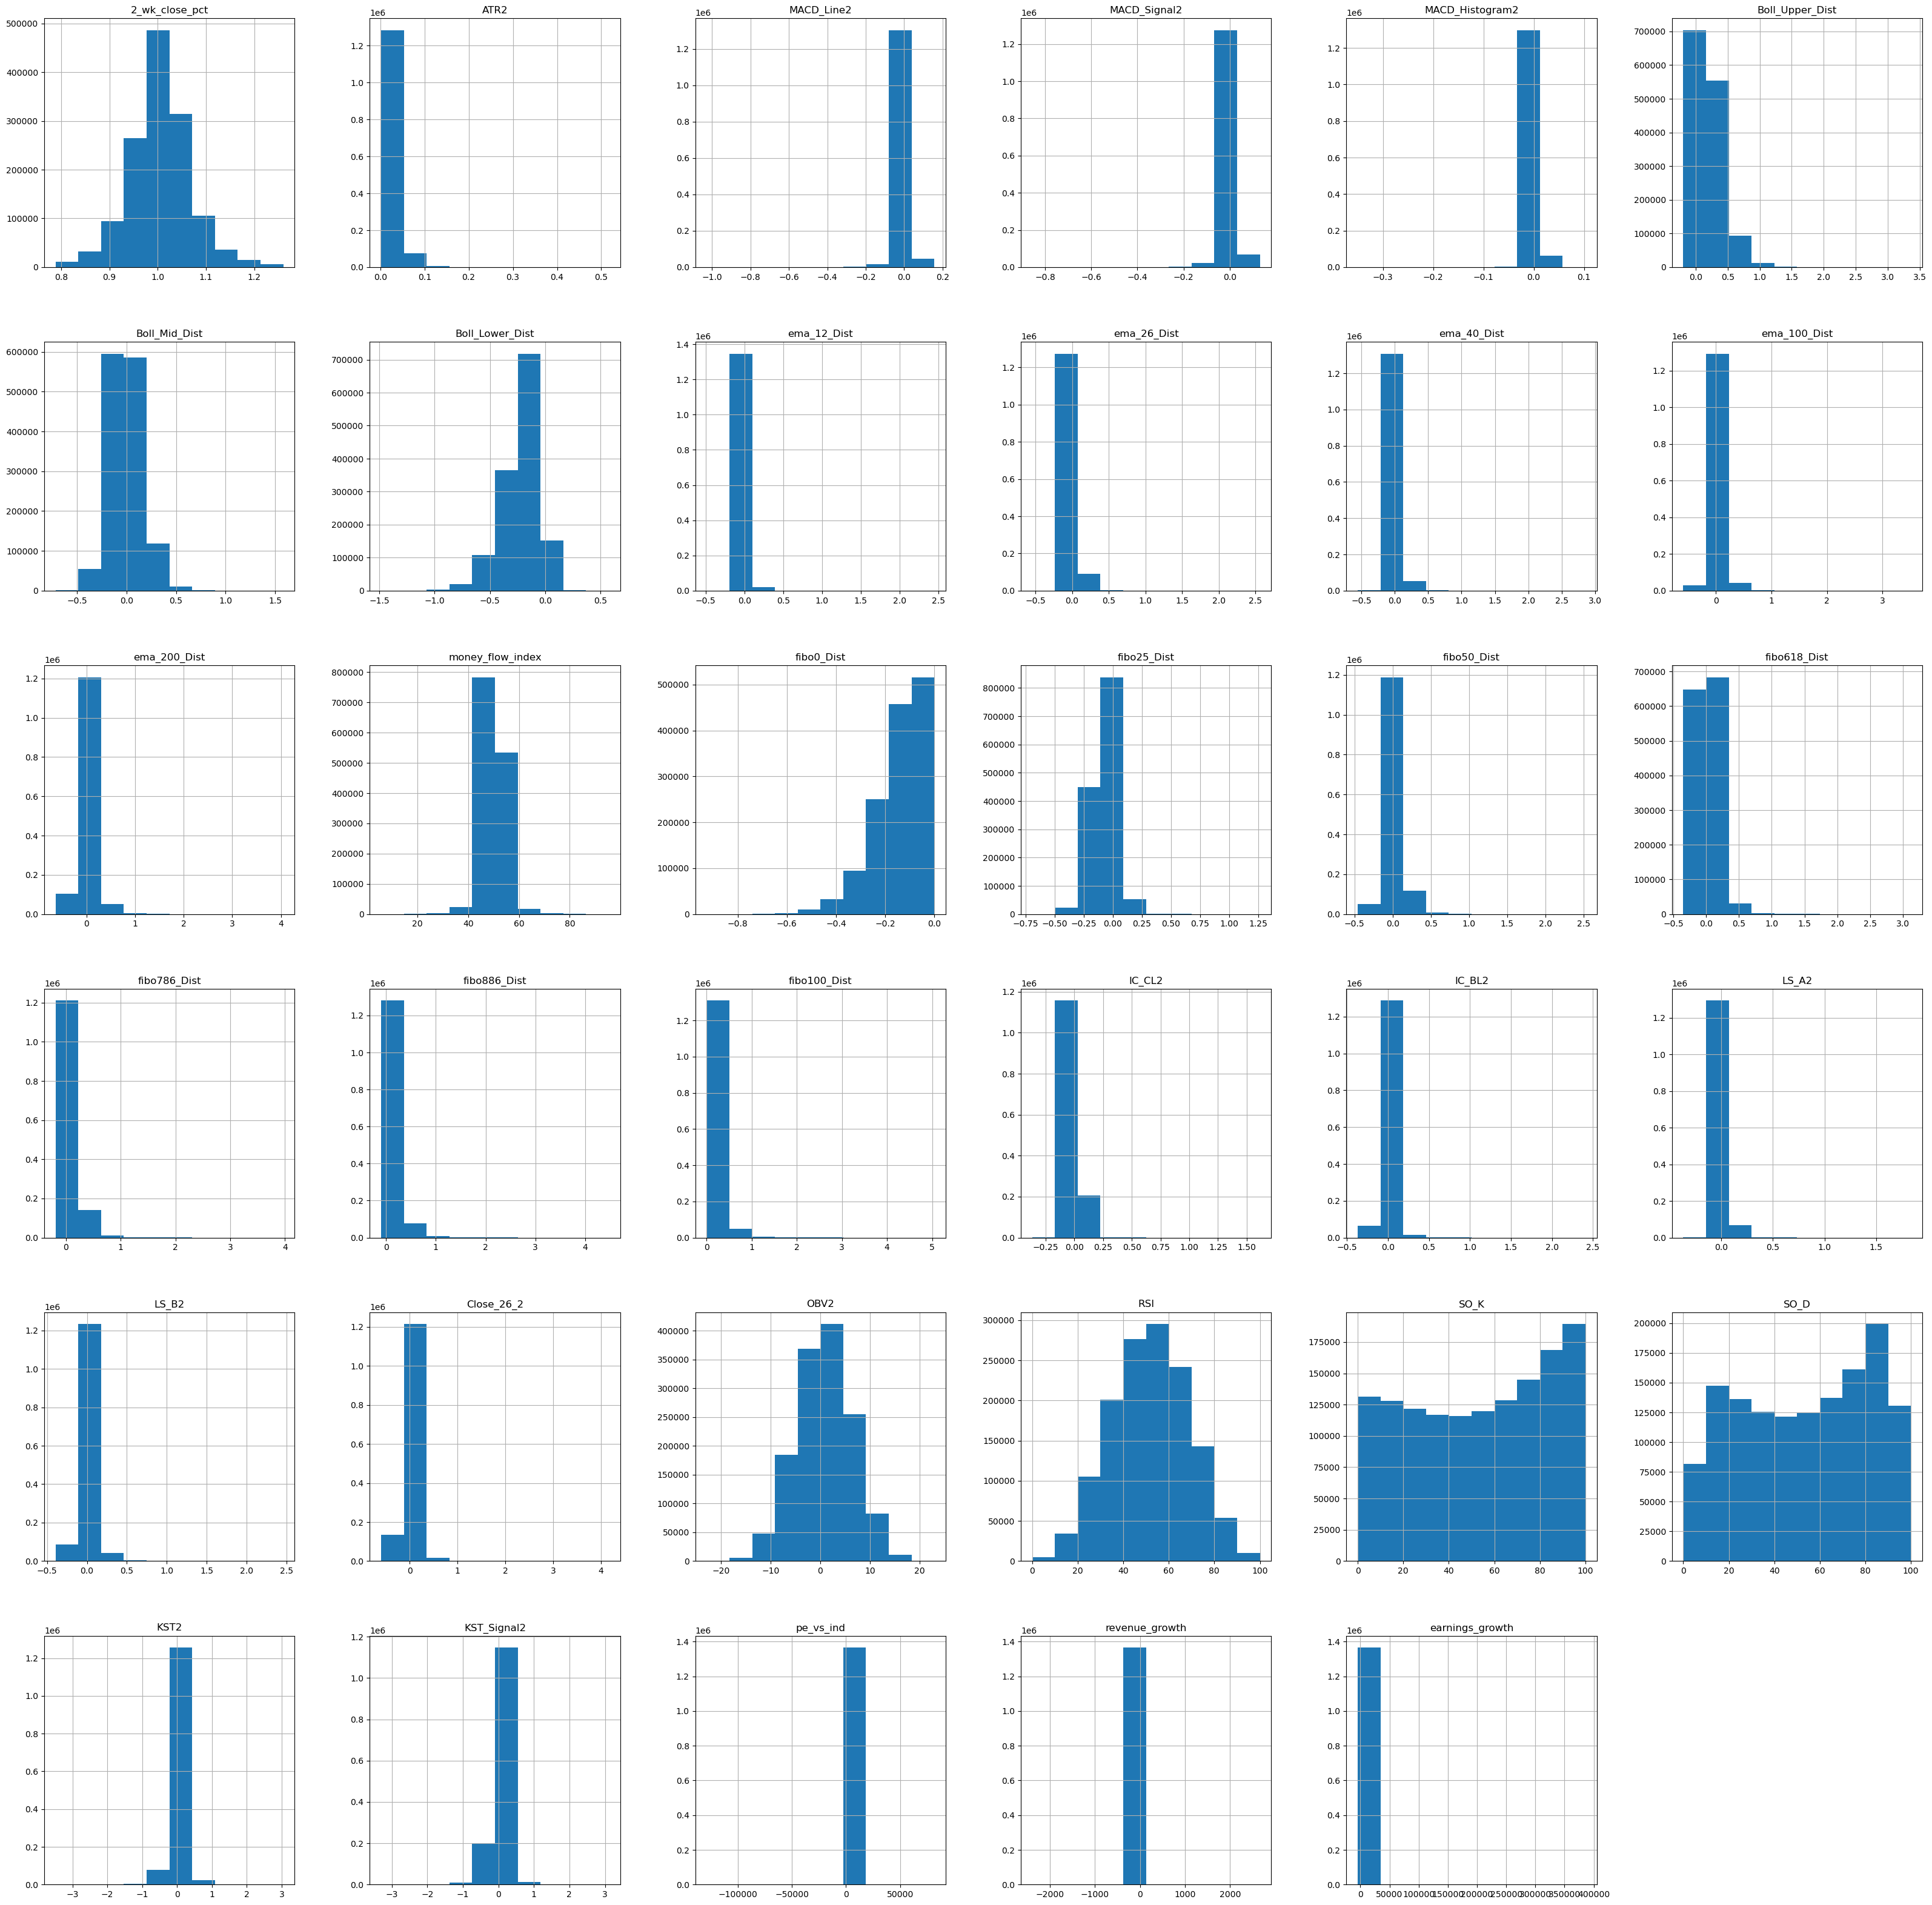

In [59]:
#hist = final_data_precursor['MACD_Line2'].hist(bins=10)

fig = plt.figure(figsize = (40,40))
ax = fig.gca()
hist_table.hist(ax = ax)

#### We see a lot of tall bars, this is indicative of outliers which should be removed

In [60]:
final_data_precursor = final_data_precursor[final_data_precursor['2_wk_close_pct'] < (final_data_precursor['2_wk_close_pct'].mean() + (final_data_precursor['2_wk_close_pct'].std()*3))]
final_data_precursor = final_data_precursor[final_data_precursor['2_wk_close_pct'] > (final_data_precursor['2_wk_close_pct'].mean() - (final_data_precursor['2_wk_close_pct'].std()*3))]                                         

## Variable Outlier Removal

In [61]:

hist_table2 = hist_table.dropna().copy()
hist_table2 = hist_table2.drop(columns = ['Industry','Sector']).copy()
hist_table3 = hist_table2[(np.abs(stats.zscore(hist_table2)) < 3).all(axis=1)].copy()

C:\Users\Eric\AppData\Local\Temp\ipykernel_23236\3285260031.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist_table3.hist(ax = ax)


array([[<Axes: title={'center': '2_wk_close_pct'}>,
        <Axes: title={'center': 'ATR2'}>,
        <Axes: title={'center': 'MACD_Line2'}>,
        <Axes: title={'center': 'MACD_Signal2'}>,
        <Axes: title={'center': 'MACD_Histogram2'}>,
        <Axes: title={'center': 'Boll_Upper_Dist'}>],
       [<Axes: title={'center': 'Boll_Mid_Dist'}>,
        <Axes: title={'center': 'Boll_Lower_Dist'}>,
        <Axes: title={'center': 'ema_12_Dist'}>,
        <Axes: title={'center': 'ema_26_Dist'}>,
        <Axes: title={'center': 'ema_40_Dist'}>,
        <Axes: title={'center': 'ema_100_Dist'}>],
       [<Axes: title={'center': 'ema_200_Dist'}>,
        <Axes: title={'center': 'money_flow_index'}>,
        <Axes: title={'center': 'fibo0_Dist'}>,
        <Axes: title={'center': 'fibo25_Dist'}>,
        <Axes: title={'center': 'fibo50_Dist'}>,
        <Axes: title={'center': 'fibo618_Dist'}>],
       [<Axes: title={'center': 'fibo786_Dist'}>,
        <Axes: title={'center': 'fibo886_Dist'}>

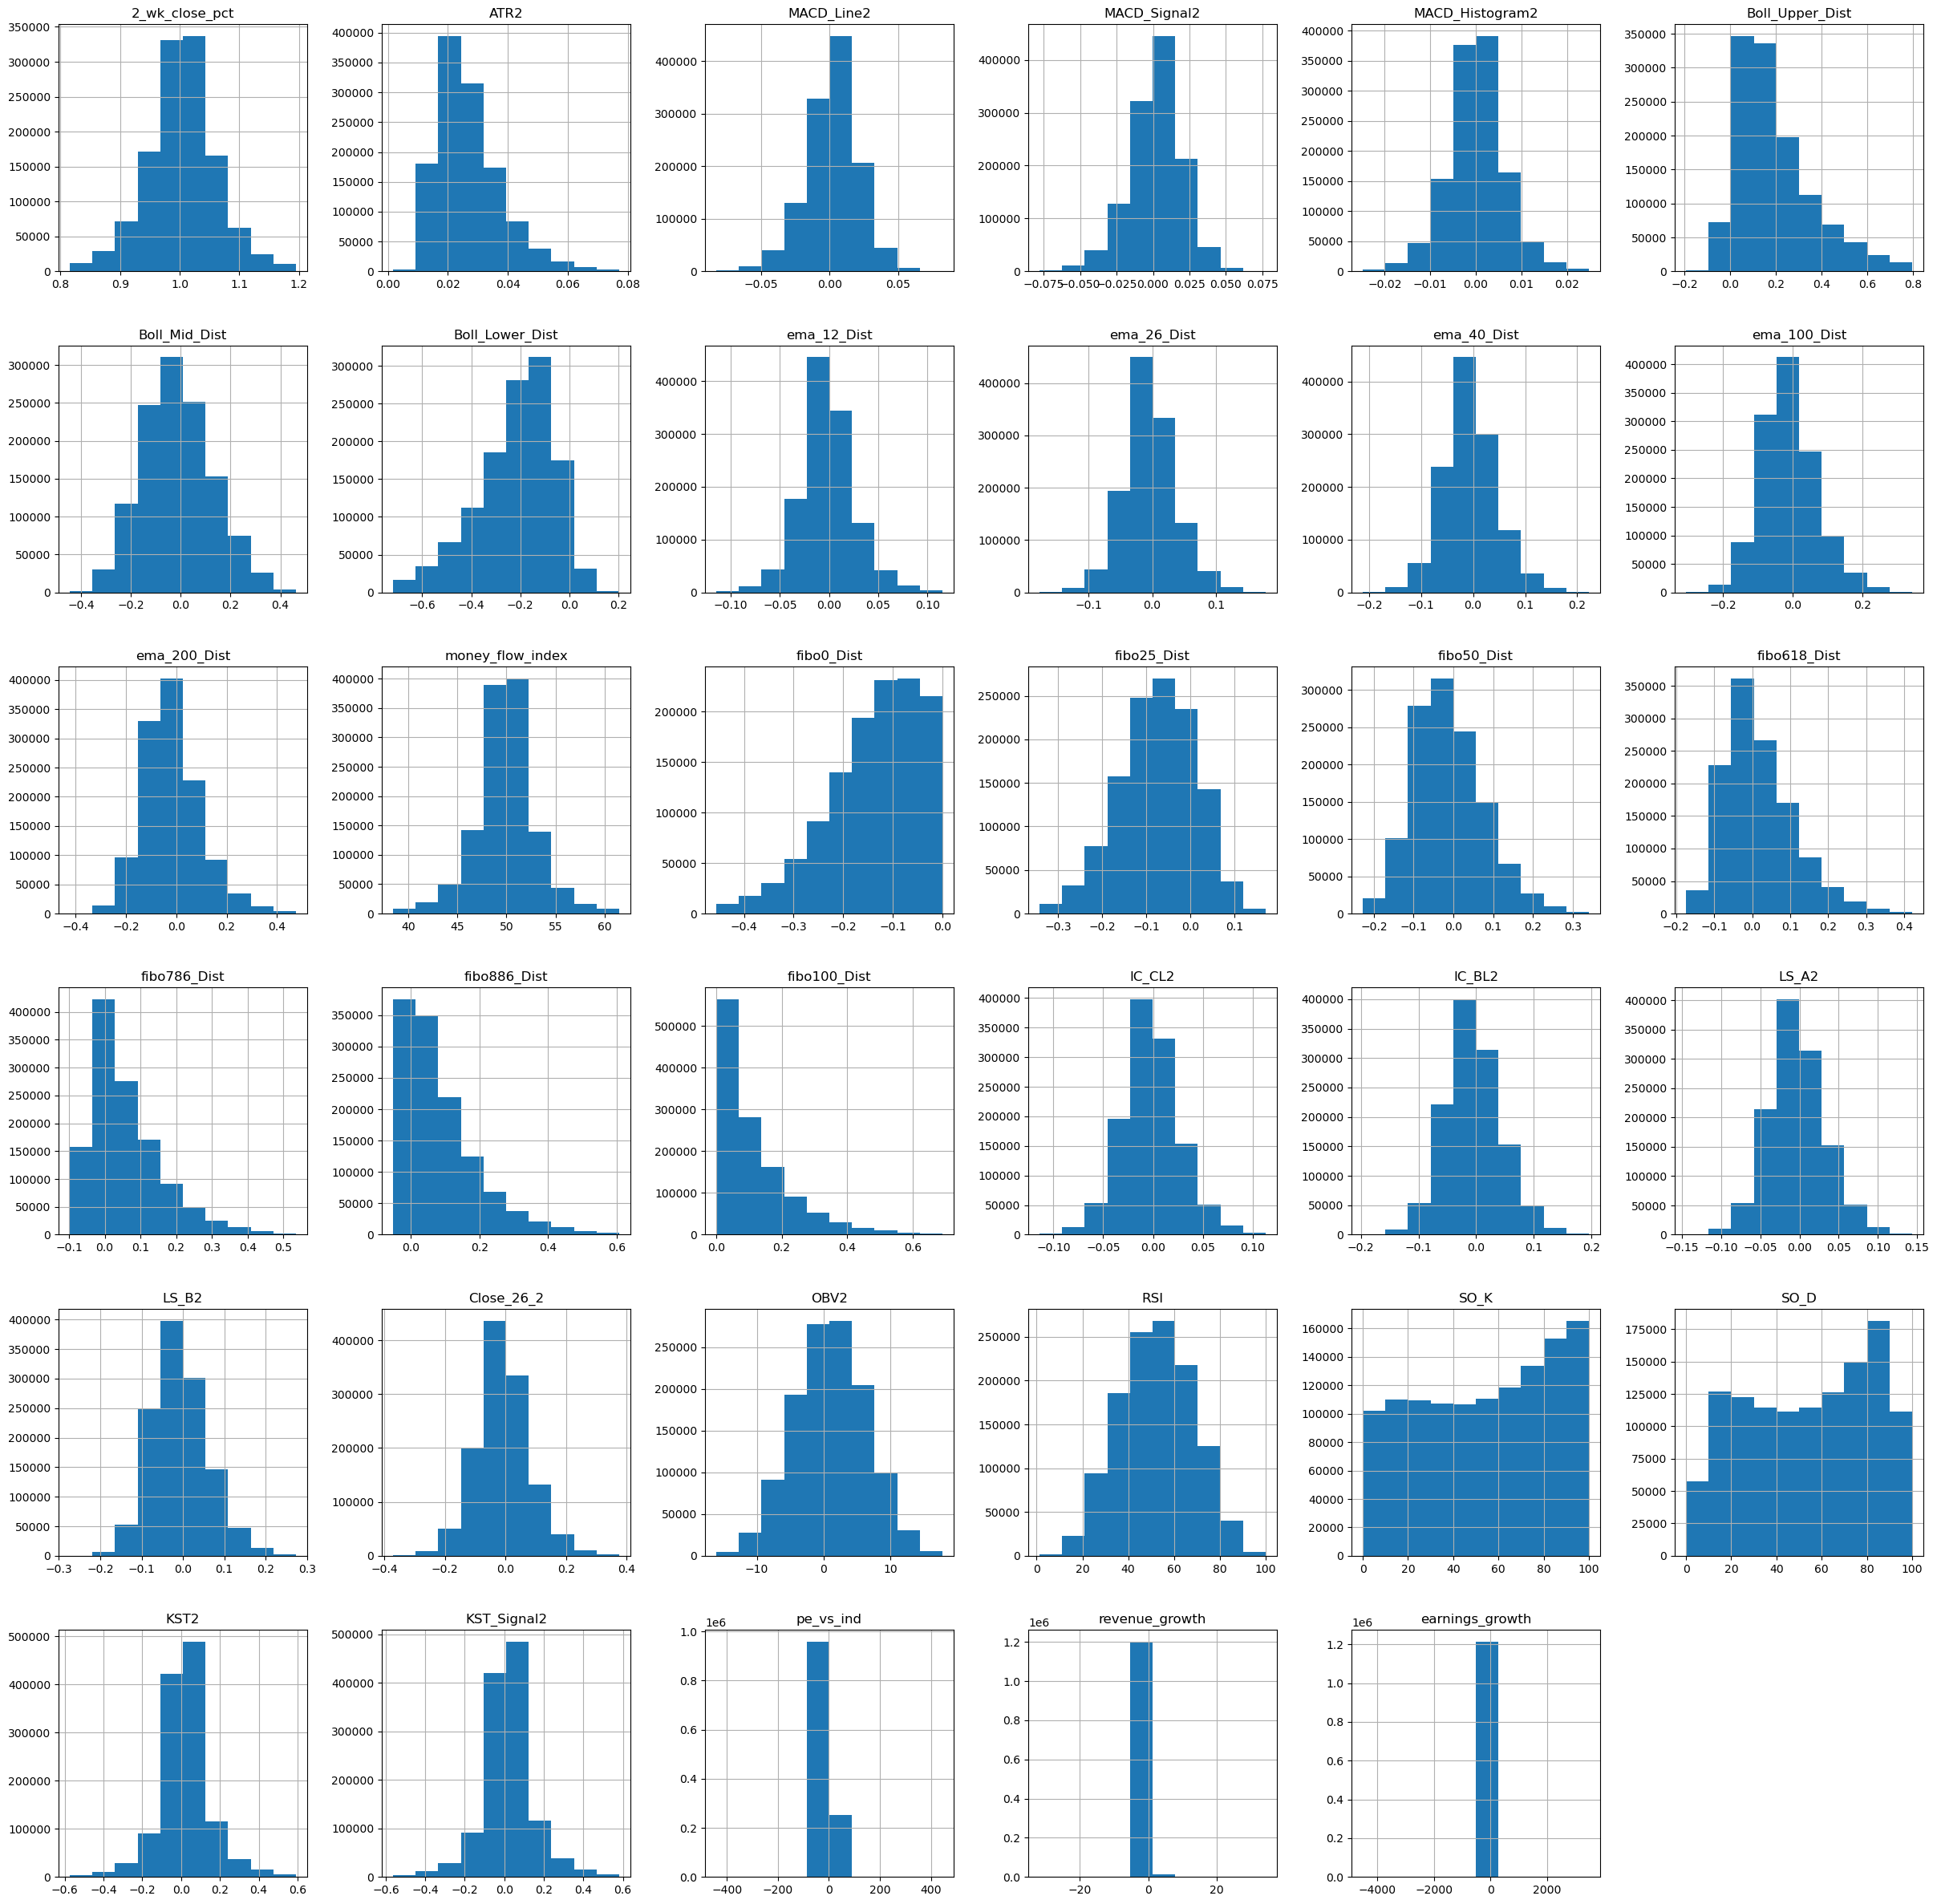

In [62]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
hist_table3.hist(ax = ax)

#### This looks significantly better.  We can go one step further and leverage min/max scaling

In [63]:
final_data_precursor[final_data_precursor['earnings_growth'] > 100]

Unnamed: 0.2  Unnamed: 0   open   high    low  close  \
ticker date2                                                              
PCRX   2015-10-01        206837        1018  41.16  41.33  38.00  39.55   
       2015-10-02        207516        1018  38.89  40.85  38.46  40.74   
       2015-10-05        208195        1018  41.22  43.03  40.93  42.75   
       2015-10-06        208874        1018  42.08  42.08  36.42  36.62   
       2015-10-07        209554        1019  36.49  39.49  35.78  38.54   
...                         ...         ...    ...    ...    ...    ...   
MPC    2018-09-24       3351756        1211  83.94  86.36  83.70  85.79   
       2018-09-25       3352587        1212  86.67  88.45  84.94  85.05   
       2018-09-26       3353418        1212  84.71  85.21  82.45  84.53   
       2018-09-27       3354249        1213  84.78  85.95  82.71  83.04   
       2018-09-28       3355080        1215  82.45  83.00  79.97  79.97   

                     volume  Unnamed: 0.1 Ticker Report Date  ...  \
ticker date2                                                  ...   
PCRX   2015-10-01   1207300         70544   PCRX  2015-09-30  ...   
       2015-10-02    908300         70544   PCRX  2015-09-30  ...   
       2015-10-05    824300         70544   PCRX  2015-09-30  ...   
       2015-10-06   2323900         70544   PCRX  2015-09-30  ...   
       2015-10-07   1601000         70544   PCRX  2015-09-30  ...   
...                     ...           ...    ...         ...  ...   
MPC    2018-09-24   6852900         60737    MPC  2018-06-30  ...   
       2018-09-25   7512300         60737    MPC  2018-06-30  ...   
       2018-09-26   7954900         60737    MPC  2018-06-30  ...   
       2018-09-27   8087900         60737    MPC  2018-06-30  ...   
       2018-09-28  39153700         60737    MPC  2018-06-30  ...   

                   SO_D_scaled KST_scaled KST_Signal_scaled  earnings_decile  \
ticker date2                                                                   
PCRX   2015-10-01     0.063448   0.436376          0.423277                9   
       2015-10-02     0.066962   0.432460          0.420773                9   
       2015-10-05     0.097963   0.430086          0.418149                9   
       2015-10-06     0.083227   0.418520          0.410508                9   
       2015-10-07     0.081860   0.415588          0.406912                9   
...                        ...        ...               ...              ...   
MPC    2018-09-24     0.661215   0.469882          0.445995                9   
       2018-09-25     0.730583   0.469731          0.445794                9   
       2018-09-26     0.697243   0.469482          0.445532                9   
       2018-09-27     0.522147   0.469340          0.445344                9   
       2018-09-28     0.331456   0.469022          0.445281                9   

                   revenue_decile  pe_vs_ind_decile  ema_12v26 ema_26v40  \
ticker date2                                                               
PCRX   2015-10-01               7                 8         -1        -1   
       2015-10-02               7                 8         -1        -1   
       2015-10-05               7                 8         -1        -1   
       2015-10-06               7                 8         -1        -1   
       2015-10-07               7                 8         -1        -1   
...                           ...               ...        ...       ...   
MPC    2018-09-24               8                 3          1         1   
       2018-09-25               8                 3          1         1   
       2018-09-26               8                 3          1         1   
       2018-09-27               8                 3          1         1   
       2018-09-28               8                 3          1         1   

                   ema_40v100  ema_100v200  
ticker date2                                
PCRX   2015-10-01        

In [64]:
hist_table3['revenue_growth'].max()

34.30573248407644

## Feature Rescaling

In [65]:
final_data_precursor['2_wk_close_pct_scaled'] = (final_data_precursor['2_wk_close_pct'] - 
                                       final_data_precursor['2_wk_close_pct'].min()) / (final_data_precursor['2_wk_close_pct'].max() - final_data_precursor['2_wk_close_pct'].min())

final_data_precursor['ATR2_scaled'] = (final_data_precursor['ATR2'] - 
                                       final_data_precursor['ATR2'].min()) / (final_data_precursor['ATR2'].max() - final_data_precursor['ATR2'].min())

final_data_precursor['MACD_Line_scaled'] = (final_data_precursor['MACD_Line2'] - 
                                       final_data_precursor['MACD_Line2'].min()) / (final_data_precursor['MACD_Line2'].max() - final_data_precursor['MACD_Line2'].min())

final_data_precursor['MACD_Signal_scaled'] = (final_data_precursor['MACD_Signal2'] - 
                                       final_data_precursor['MACD_Signal2'].min()) / (final_data_precursor['MACD_Signal2'].max() - final_data_precursor['MACD_Signal2'].min())

final_data_precursor['MACD_Histogram_scaled'] = (final_data_precursor['MACD_Histogram2'] - 
                                       final_data_precursor['MACD_Histogram2'].min()) / (final_data_precursor['MACD_Histogram2'].max() - final_data_precursor['MACD_Histogram2'].min())

final_data_precursor['Boll_Upper_scaled'] = (final_data_precursor['Boll_Upper_Dist'] - 
                                       final_data_precursor['Boll_Upper_Dist'].min()) / (final_data_precursor['Boll_Upper_Dist'].max() - final_data_precursor['Boll_Upper_Dist'].min())

final_data_precursor['Boll_Mid_scaled'] = (final_data_precursor['Boll_Mid_Dist'] - 
                                       final_data_precursor['Boll_Mid_Dist'].min()) / (final_data_precursor['Boll_Mid_Dist'].max() - final_data_precursor['Boll_Mid_Dist'].min())

final_data_precursor['Boll_Lower_scaled'] = (final_data_precursor['Boll_Lower_Dist'] - 
                                       final_data_precursor['Boll_Lower_Dist'].min()) / (final_data_precursor['Boll_Lower_Dist'].max() - final_data_precursor['Boll_Lower_Dist'].min())

final_data_precursor['ema_12_Dist_scaled'] = (final_data_precursor['ema_12_Dist'] - 
                                       final_data_precursor['ema_12_Dist'].min()) / (final_data_precursor['ema_12_Dist'].max() - final_data_precursor['ema_12_Dist'].min())

final_data_precursor['ema_26_Dist_scaled'] = (final_data_precursor['ema_26_Dist'] - 
                                       final_data_precursor['ema_26_Dist'].min()) / (final_data_precursor['ema_26_Dist'].max() - final_data_precursor['ema_26_Dist'].min())

final_data_precursor['ema_40_Dist_scaled'] = (final_data_precursor['ema_40_Dist'] - 
                                       final_data_precursor['ema_40_Dist'].min()) / (final_data_precursor['ema_40_Dist'].max() - final_data_precursor['ema_40_Dist'].min())

final_data_precursor['ema_100_Dist_scaled'] = (final_data_precursor['ema_100_Dist'] - 
                                       final_data_precursor['ema_100_Dist'].min()) / (final_data_precursor['ema_100_Dist'].max() - final_data_precursor['ema_100_Dist'].min())

final_data_precursor['ema_200_Dist_scaled'] = (final_data_precursor['ema_200_Dist'] - 
                                       final_data_precursor['ema_200_Dist'].min()) / (final_data_precursor['ema_200_Dist'].max() - final_data_precursor['ema_200_Dist'].min())

final_data_precursor['money_flow_index_scaled'] = (final_data_precursor['money_flow_index'] - 
                                       final_data_precursor['money_flow_index'].min()) / (final_data_precursor['money_flow_index'].max() - final_data_precursor['money_flow_index'].min())

final_data_precursor['fibo0_Dist_scaled'] = (final_data_precursor['fibo0_Dist'] - 
                                       final_data_precursor['fibo0_Dist'].min()) / (final_data_precursor['fibo0_Dist'].max() - final_data_precursor['fibo0_Dist'].min())

final_data_precursor['fibo25_Dist_scaled'] = (final_data_precursor['fibo25_Dist'] - 
                                       final_data_precursor['fibo25_Dist'].min()) / (final_data_precursor['fibo25_Dist'].max() - final_data_precursor['fibo25_Dist'].min())

final_data_precursor['fibo50_Dist_scaled'] = (final_data_precursor['fibo50_Dist'] - 
                                       final_data_precursor['fibo50_Dist'].min()) / (final_data_precursor['fibo50_Dist'].max() - final_data_precursor['fibo50_Dist'].min())

final_data_precursor['fibo618_Dist_scaled'] = (final_data_precursor['fibo618_Dist'] - 
                                       final_data_precursor['fibo618_Dist'].min()) / (final_data_precursor['fibo618_Dist'].max() - final_data_precursor['fibo618_Dist'].min())

final_data_precursor['fibo786_Dist_scaled'] = (final_data_precursor['fibo786_Dist'] - 
                                       final_data_precursor['fibo786_Dist'].min()) / (final_data_precursor['fibo786_Dist'].max() - final_data_precursor['fibo786_Dist'].min())

final_data_precursor['fibo886_Dist_scaled'] = (final_data_precursor['fibo886_Dist'] - 
                                       final_data_precursor['fibo886_Dist'].min()) / (final_data_precursor['fibo886_Dist'].max() - final_data_precursor['fibo886_Dist'].min())

final_data_precursor['fibo100_Dist_scaled'] = (final_data_precursor['fibo100_Dist'] - 
                                       final_data_precursor['fibo100_Dist'].min()) / (final_data_precursor['fibo100_Dist'].max() - final_data_precursor['fibo100_Dist'].min())

final_data_precursor['IC_CL2_scaled'] = (final_data_precursor['IC_CL2'] - 
                                       final_data_precursor['IC_CL2'].min()) / (final_data_precursor['IC_CL2'].max() - final_data_precursor['IC_CL2'].min())


final_data_precursor['IC_BL2_scaled'] = (final_data_precursor['IC_BL2'] - 
                                       final_data_precursor['IC_BL2'].min()) / (final_data_precursor['IC_BL2'].max() - final_data_precursor['IC_BL2'].min())


final_data_precursor['LS_A2_scaled'] = (final_data_precursor['LS_A2'] - 
                                       final_data_precursor['LS_A2'].min()) / (final_data_precursor['LS_A2'].max() - final_data_precursor['LS_A2'].min())


final_data_precursor['LS_B2_scaled'] = (final_data_precursor['LS_B2'] - 
                                       final_data_precursor['LS_B2'].min()) / (final_data_precursor['LS_B2'].max() - final_data_precursor['LS_B2'].min())

final_data_precursor['Close_26_2_scaled'] = (final_data_precursor['Close_26_2'] - 
                                       final_data_precursor['Close_26_2'].min()) / (final_data_precursor['Close_26_2'].max() - final_data_precursor['Close_26_2'].min())

final_data_precursor['OBV2_scaled'] = (final_data_precursor['OBV2'] - 
                                       final_data_precursor['OBV2'].min()) / (final_data_precursor['OBV2'].max() - final_data_precursor['OBV2'].min())


final_data_precursor['RSI_scaled'] = (final_data_precursor['RSI'] - 
                                       final_data_precursor['RSI'].min()) / (final_data_precursor['RSI'].max() - final_data_precursor['RSI'].min())

final_data_precursor['SO_K_scaled'] = (final_data_precursor['SO_K'] - 
                                       final_data_precursor['SO_K'].min()) / (final_data_precursor['SO_K'].max() - final_data_precursor['SO_K'].min())

final_data_precursor['SO_D_scaled'] = (final_data_precursor['SO_D'] - 
                                       final_data_precursor['SO_D'].min()) / (final_data_precursor['SO_D'].max() - final_data_precursor['SO_D'].min())

final_data_precursor['KST_scaled'] = (final_data_precursor['KST2'] - 
                                       final_data_precursor['KST2'].min()) / (final_data_precursor['KST2'].max() - final_data_precursor['KST2'].min())

final_data_precursor['KST_Signal_scaled'] = (final_data_precursor['KST_Signal2'] - 
                                       final_data_precursor['KST_Signal2'].min()) / (final_data_precursor['KST_Signal2'].max() - final_data_precursor['KST_Signal2'].min())

In [66]:
final_data_precursor.replace([np.inf, -np.inf], np.nan, inplace=True)
final_data_precursor = final_data_precursor.dropna()

In [67]:
final_data_precursor

Unnamed: 0.2  Unnamed: 0    open    high      low   close  \
ticker date2                                                                   
A      2015-05-01       2690468           0   41.41   41.93   41.240   41.83   
       2015-05-04       2691131           0   41.88   42.08   41.700   41.94   
       2015-05-05       2691794           0   41.72   41.85   41.460   41.59   
       2015-05-06       2692457           0   41.86   41.86   41.360   41.59   
       2015-05-07       2693120           0   41.59   41.85   41.310   41.80   
...                         ...         ...     ...     ...      ...     ...   
WU     2020-11-11       3844899        2283   21.77   21.89   20.770   21.03   
V      2020-11-12       3845787        2172  211.43  212.54  207.140  208.26   
WU     2020-11-12       3845838        2284   20.94   21.11   20.635   20.86   
V      2020-11-13       3846726        2172  209.91  211.28  207.300  210.48   
WU     2020-11-13       3846777        2284   20.99   21.34   20.915   21.24   

                    volume  Unnamed: 0.1 Ticker Report Date  ...  SO_D_scaled  \
ticker date2                                                 ...                
A      2015-05-01  1880100             4      A  2015-04-30  ...     0.213526   
       2015-05-04  1073800             4      A  2015-04-30  ...     0.245831   
       2015-05-05  1254800             4      A  2015-04-30  ...     0.277830   
       2015-05-06   934600             4      A  2015-04-30  ...     0.246816   
       2015-05-07   999600             4      A  2015-04-30  ...     0.230126   
...                    ...           ...    ...         ...  ...          ...   
WU     2020-11-11  6177300        101531     WU  2020-09-30  ...     0.671996   
V      2020-11-12  7303800         95932      V  2020-09-30  ...     0.837932   
WU     2020-11-12  3751900        101531     WU  2020-09-30  ...     0.629720   
V      2020-11-13  6378500         95932      V  2020-09-30  ...     0.813378   
WU     2020-11-13  3215100        101531     WU  2020-09-30  ...     0.605896   

                  KST_scaled KST_Signal_scaled  earnings_decile  \
ticker date2                                                      
A      2015-05-01   0.548929          0.524988                8   
       2015-05-04   0.548048          0.524559                8   
       2015-05-05   0.547038          0.524072                8   
       2015-05-06   0.545903          0.523342                8   
       2015-05-07   0.545026          0.522501                8   
...                      ...               ...              ...   
WU     2020-11-11   0.507014          0.480536                6   
V      2020-11-12   0.539824          0.512611                7   
WU     2020-11-12   0.506396          0.479752                6   
V      2020-11-13   0.540230          0.512782                7   
WU     2020-11-13   0.508603          0.480237                6   

                   revenue_decile  pe_vs_ind_decile  ema_12v26 ema_26v40  \
ticker date2                                                               
A      2015-05-01               2                 2          1         1   
       2015-05-04               2                 2         -1         1   
       2015-05-05               2                 2         -1         1   
       2015-05-06               2                 2         -1         1   
       2015-05-07               2                 2         -1         1   
...                           ...               ...        ...       ...   
WU     2020-11-11               1                 2         -1        -1   
V      2020-11-12               0                 7          1         1   
WU     2020-11-12               1                 2         -1        -1   
V      2020-11-13               0                 7          1         1   
WU     2020-11-13               1                 2         -1        -1   

                   ema_40v100  ema_100v200  
ticker date2      

In [68]:
final_data_precursor['earnings_decile'] = pd.qcut(final_data_precursor['earnings_growth'], 10, labels=False)
final_data_precursor['revenue_decile'] = pd.qcut(final_data_precursor['revenue_growth'], 10, labels=False)
final_data_precursor['pe_vs_ind_decile'] = pd.qcut(final_data_precursor['pe_vs_ind'], 10, labels=False)

# Signal Transformation to Indicators

## EMA Crossover

In [69]:

final_data_precursor['ema_12v26'] = np.where(final_data_precursor['ema_12'] > final_data_precursor['ema_26'],1,-1)
final_data_precursor['ema_26v40'] = np.where(final_data_precursor['ema_26'] > final_data_precursor['ema_40'],1,-1)
final_data_precursor['ema_40v100'] = np.where(final_data_precursor['ema_40'] > final_data_precursor['ema_100'],1,-1)
final_data_precursor['ema_100v200'] = np.where(final_data_precursor['ema_100'] > final_data_precursor['ema_200'],1,-1)

final_data_precursor['ema_12v26_roll5'] = final_data_precursor['ema_12v26'].groupby(level=["ticker"]).rolling(min_periods=5, window=5).sum().droplevel(0,axis = 0)
final_data_precursor['ema_12v26_roll10'] = final_data_precursor['ema_12v26'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).sum().droplevel(0,axis = 0)

final_data_precursor['ema_26v40_roll5'] = final_data_precursor['ema_26v40'].groupby(level=["ticker"]).rolling(min_periods=5, window=5).sum().droplevel(0,axis = 0)
final_data_precursor['ema_26v40_roll10'] = final_data_precursor['ema_26v40'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).sum().droplevel(0,axis = 0)

final_data_precursor['ema_40v100_roll5'] = final_data_precursor['ema_40v100'].groupby(level=["ticker"]).rolling(min_periods=5, window=5).sum().droplevel(0,axis = 0)
final_data_precursor['ema_40v100_roll10'] = final_data_precursor['ema_40v100'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).sum().droplevel(0,axis = 0)

final_data_precursor['ema_100v200_roll5'] = final_data_precursor['ema_100v200'].groupby(level=["ticker"]).rolling(min_periods=5, window=5).sum().droplevel(0,axis = 0)
final_data_precursor['ema_100v200_roll10'] = final_data_precursor['ema_100v200'].groupby(level=["ticker"]).rolling(min_periods=10, window=10).sum().droplevel(0,axis = 0)


final_data_precursor['ema_12v26_cross_up_flg'] = np.where((final_data_precursor['ema_12v26_roll5'] > 0) & (final_data_precursor['ema_12v26_roll5'] > final_data_precursor['ema_12v26_roll10']),1,0)
final_data_precursor['ema_12v26_cross_dn_flg'] = np.where((final_data_precursor['ema_12v26_roll5'] < 0) & (final_data_precursor['ema_12v26_roll5'] < final_data_precursor['ema_12v26_roll10']),1,0)

final_data_precursor['ema_26v40_cross_up_flg'] = np.where((final_data_precursor['ema_26v40_roll5'] > 0) & (final_data_precursor['ema_26v40_roll5'] > final_data_precursor['ema_26v40_roll10']),1,0)
final_data_precursor['ema_26v40_cross_dn_flg'] = np.where((final_data_precursor['ema_26v40_roll5'] < 0) & (final_data_precursor['ema_26v40_roll5'] < final_data_precursor['ema_26v40_roll10']),1,0)

final_data_precursor['ema_40v100_cross_up_flg'] = np.where((final_data_precursor['ema_40v100_roll5'] > 0) & (final_data_precursor['ema_40v100_roll5'] > final_data_precursor['ema_40v100_roll10']),1,0)
final_data_precursor['ema_40v100_cross_dn_flg'] = np.where((final_data_precursor['ema_40v100_roll5'] < 0) & (final_data_precursor['ema_40v100_roll5'] < final_data_precursor['ema_40v100_roll10']),1,0)

final_data_precursor['ema_100v200_cross_up_flg'] = np.where((final_data_precursor['ema_100v200_roll5'] > 0) & (final_data_precursor['ema_100v200_roll5'] > final_data_precursor['ema_100v200_roll10']),1,0)
final_data_precursor['ema_100v200_cross_dn_flg'] = np.where((final_data_precursor['ema_100v200_roll5'] < 0) & (final_data_precursor['ema_100v200_roll5'] < final_data_precursor['ema_100v200_roll10']),1,0)


final_data_precursor = final_data_precursor.drop(columns = ['ema_12v26','ema_26v40', 'ema_40v100','ema_100v200', \
                                                           'ema_12v26_roll5','ema_12v26_roll10' \
                                                           ,'ema_26v40_roll5','ema_26v40_roll10' \
                                                           ,'ema_40v100_roll5','ema_40v100_roll10' \
                                                           ,'ema_100v200_roll5','ema_100v200_roll10'])

# Data Modelling

## Close Ranking

In [70]:
final_data_precursor.replace([np.inf, -np.inf], np.nan, inplace=True)
final_data = final_data_precursor.dropna()
final_data = final_data[['2_wk_close_pct_scaled','ATR2_scaled','MACD_Line_scaled','MACD_Signal_scaled' \
                                        ,'MACD_Histogram_scaled','Boll_Upper_scaled','Boll_Mid_scaled','Boll_Lower_scaled' \
                                        ,'ema_12_Dist_scaled','ema_26_Dist_scaled','ema_40_Dist_scaled','ema_100_Dist_scaled' \
                                        ,'ema_200_Dist_scaled','money_flow_index_scaled','fibo0_Dist_scaled','fibo25_Dist_scaled' \
                                        ,'fibo50_Dist_scaled','fibo618_Dist_scaled','fibo786_Dist_scaled','fibo886_Dist_scaled' \
                                        ,'fibo100_Dist_scaled','IC_CL2_scaled','IC_BL2_scaled','LS_A2_scaled' \
                                        ,'LS_B2_scaled','Close_26_2_scaled','OBV2_scaled','RSI_scaled' \
                                        ,'SO_K_scaled','SO_D_scaled','KST_scaled','KST_Signal_scaled','pe_vs_ind_decile' \
                                        ,'revenue_decile', 'earnings_decile','earnings_1wk', 'earnings_2wk', 'earnings_4wk','earnings_8wk', 'Industry','Sector'
                                       ]]



#### Remove entries where earnings are within decision window as earnings are unpredicable

In [71]:
hist_table

2_wk_close_pct      ATR2  MACD_Line2  MACD_Signal2  \
ticker date2                                                            
A      2015-05-01        1.005020  0.014378    0.000042      0.004721   
       2015-05-04        1.016452  0.013931   -0.000480      0.003671   
       2015-05-05        1.018755  0.014032   -0.001563      0.002649   
       2015-05-06        1.024525  0.014341   -0.002391      0.001641   
       2015-05-07        1.012440  0.014286   -0.002596      0.000787   
...                           ...       ...         ...           ...   
WU     2020-11-11        1.073704  0.039960   -0.011707     -0.016384   
V      2020-11-12        1.013157  0.033087    0.011663     -0.001888   
WU     2020-11-12        1.079578  0.040012   -0.011490     -0.015512   
V      2020-11-13        0.999382  0.031614    0.013939      0.001294   
WU     2020-11-13        1.062147  0.037782   -0.009488     -0.014085   

                   MACD_Histogram2  Boll_Upper_Dist  Boll_Mid_Dist  \
ticker date2                                                         
A      2015-05-01        -0.004678         0.281641       0.109675   
       2015-05-04        -0.004151         0.264296       0.093176   
       2015-05-05        -0.004212         0.320451       0.137997   
       2015-05-06        -0.004031         0.368803       0.150990   
       2015-05-07        -0.003382         0.335143       0.110655   
...                            ...              ...            ...   
WU     2020-11-11         0.004677         0.203495       0.015330   
V      2020-11-12         0.013551         0.112929      -0.167883   
WU     2020-11-12         0.004022         0.209056       0.028449   
V      2020-11-13         0.012646         0.100701      -0.190450   
WU     2020-11-13         0.004597         0.143845      -0.023152   

                   Boll_Lower_Dist  ema_12_Dist  ema_26_Dist  ...        RSI  \
ticker date2                                                  ...              
A      2015-05-01        -0.062292     0.009160     0.009117  ...  33.333333   
       2015-05-04        -0.077945     0.005511     0.005991  ...  34.770889   
       2015-05-05        -0.044456     0.011823     0.013386  ...  26.133333   
       2015-05-06        -0.066823     0.010004     0.012395  ...  28.000000   
       2015-05-07        -0.113833     0.004172     0.006767  ...  33.426966   
...                            ...          ...          ...  ...        ...   
WU     2020-11-11        -0.172835    -0.001102     0.010605  ...  42.736077   
V      2020-11-12        -0.448695    -0.030565    -0.042229  ...  58.408532   
WU     2020-11-12        -0.152159     0.005956     0.017446  ...  43.206854   
V      2020-11-13        -0.481602    -0.034515    -0.048454  ...  64.949339   
WU     2020-11-13        -0.190149    -0.010189    -0.000701  ...  49.058971   

                        SO_K       SO_D      KST2  KST_Signal2  pe_vs_ind  \
ticker date2                                                                
A      2015-05-01  29.387755  21.352558  0.048892     0.063672   0.247859   
       2015-05-04  33.877551  24.583059  0.043225     0.060925   0.252313   
       2015-05-05  20.083682  27.782996  0.036721     0.057804   0.254491   
       2015-05-06  20.083682  24.681638  0.029413     0.053130   0.246914   
       2015-05-07  28.870293  23.012552  0.023769     0.047735   0.238741   
...                      ...        ...       ...          ...        ...   
WU     2020-11-11  57.122093  67.199612 -0.220924    -0.221171   0.303050   
V      2020-11-12  75.559604  83.793163 -0.009720    -0.015638   1.693598   
WU     2020-11-12  56.357928  62.972022 -0.224906    -0.226195   0.306402   
V      2020-11-13  81.337845  81.337845 -0.007104    -0.014543   1.691660   
WU     2020-11-13  68.288854  60.589625 -0.210696    -0.223082   0.308340   

                   revenue_growth  earnings_growth  \
ticker date2                                         
A      

In [72]:
final_data = final_data[final_data['earnings_8wk'] == 1]
final_data = final_data[final_data.index.isin(hist_table3.index)].copy()

## Determining Correllation

In [73]:
final_data

2_wk_close_pct_scaled  ATR2_scaled  MACD_Line_scaled  \
ticker date2                                                              
A      2015-05-01               0.490960     0.024598          0.867323   
       2015-05-04               0.521643     0.023732          0.866882   
       2015-05-05               0.527823     0.023926          0.865969   
       2015-05-06               0.543312     0.024526          0.865271   
       2015-05-07               0.510875     0.024419          0.865098   
...                                  ...          ...               ...   
WU     2020-11-11               0.675309     0.074241          0.857414   
V      2020-11-12               0.512798     0.060903          0.877123   
WU     2020-11-12               0.691075     0.074341          0.857598   
V      2020-11-13               0.475828     0.058046          0.879042   
WU     2020-11-13               0.644289     0.070016          0.859286   

                   MACD_Signal_scaled  MACD_Histogram_scaled  \
ticker date2                                                   
A      2015-05-01            0.872184               0.762916   
       2015-05-04            0.871119               0.764081   
       2015-05-05            0.870084               0.763947   
       2015-05-06            0.869062               0.764346   
       2015-05-07            0.868197               0.765779   
...                               ...                    ...   
WU     2020-11-11            0.850792               0.783583   
V      2020-11-12            0.865485               0.803187   
WU     2020-11-12            0.851676               0.782137   
V      2020-11-13            0.868710               0.801187   
WU     2020-11-13            0.853122               0.783407   

                   Boll_Upper_scaled  Boll_Mid_scaled  Boll_Lower_scaled  \
ticker date2                                                               
A      2015-05-01           0.146382         0.359730           0.690213   
       2015-05-04           0.141041         0.352532           0.682609   
       2015-05-05           0.158330         0.372087           0.698878   
       2015-05-06           0.173216         0.377756           0.688012   
       2015-05-07           0.162853         0.360158           0.665173   
...                              ...              ...                ...   
WU     2020-11-11           0.122323         0.318569           0.636508   
V      2020-11-12           0.094440         0.238637           0.502488   
WU     2020-11-12           0.124035         0.324293           0.646553   
V      2020-11-13           0.090676         0.228791           0.486501   
WU     2020-11-13           0.103958         0.301780           0.628097   

                   ema_12_Dist_scaled  ema_26_Dist_scaled  ...  \
ticker date2                                               ...   
A      2015-05-01            0.169027            0.178171  ...   
       2015-05-04            0.167783            0.177163  ...   
       2015-05-05            0.169934            0.179547  ...   
       2015-05-06            0.169315            0.179227  ...   
       2015-05-07            0.167327            0.177413  ...   
...                               ...                 ...  ...   
WU     2020-11-11            0.165530            0.178650  ...   
V      2020-11-12            0.155489            0.161619  ...   
WU     2020-11-12            0.167935            0.180856  ...   
V      2020-11-13            0.154143            0.159612  ...   
WU     2020-11-13            0.162433            0.175006  ...   

                   KST_Signal_scaled  pe_vs_ind_decile  revenue_decile  \
ticker date2                                                             
A      2015-05-01           0.524988                 2               2   
       2015-05-04           0.524559                 2               2   
       2015-05-05           0.524072                 2            

In [74]:
#final_data = final_data[(np.abs(stats.zscore(final_data)) < 3).all(axis=1)].copy()

In [75]:
Corr_Output = final_data.corr(method='pearson')

C:\Users\Eric\AppData\Local\Temp\ipykernel_23236\3432123448.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Corr_Output = final_data.corr(method='pearson')


In [76]:
Corr_Output2 = Corr_Output[["2_wk_close_pct_scaled"]]

<Axes: >

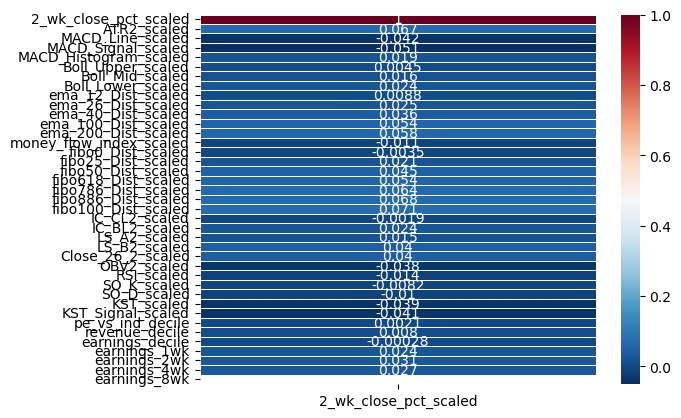

In [77]:
sns.heatmap(Corr_Output2, 
            xticklabels=Corr_Output2.columns,
            yticklabels=Corr_Output.index,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

<Axes: >

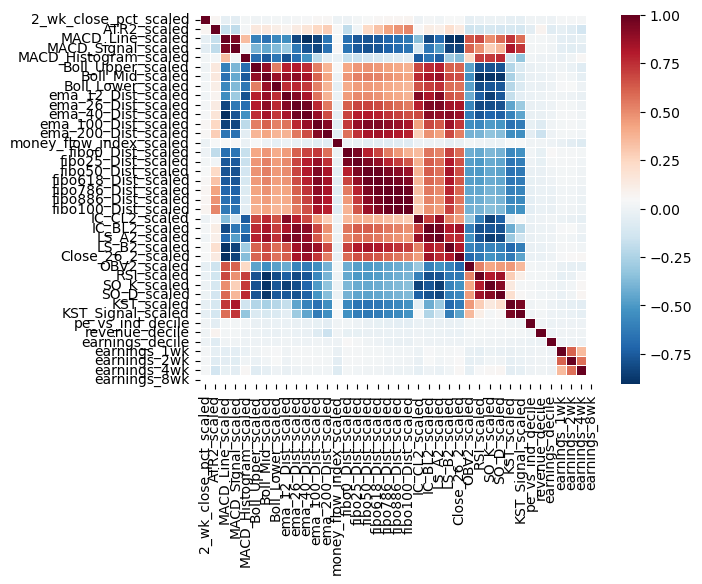

In [78]:
sns.heatmap(Corr_Output, 
            xticklabels=Corr_Output.columns,
            yticklabels=Corr_Output.index,
            cmap='RdBu_r',
            annot=False,
            linewidth=0.5)

In [79]:
Corr_Output.to_csv("F:/Stocks/corr_data.csv")

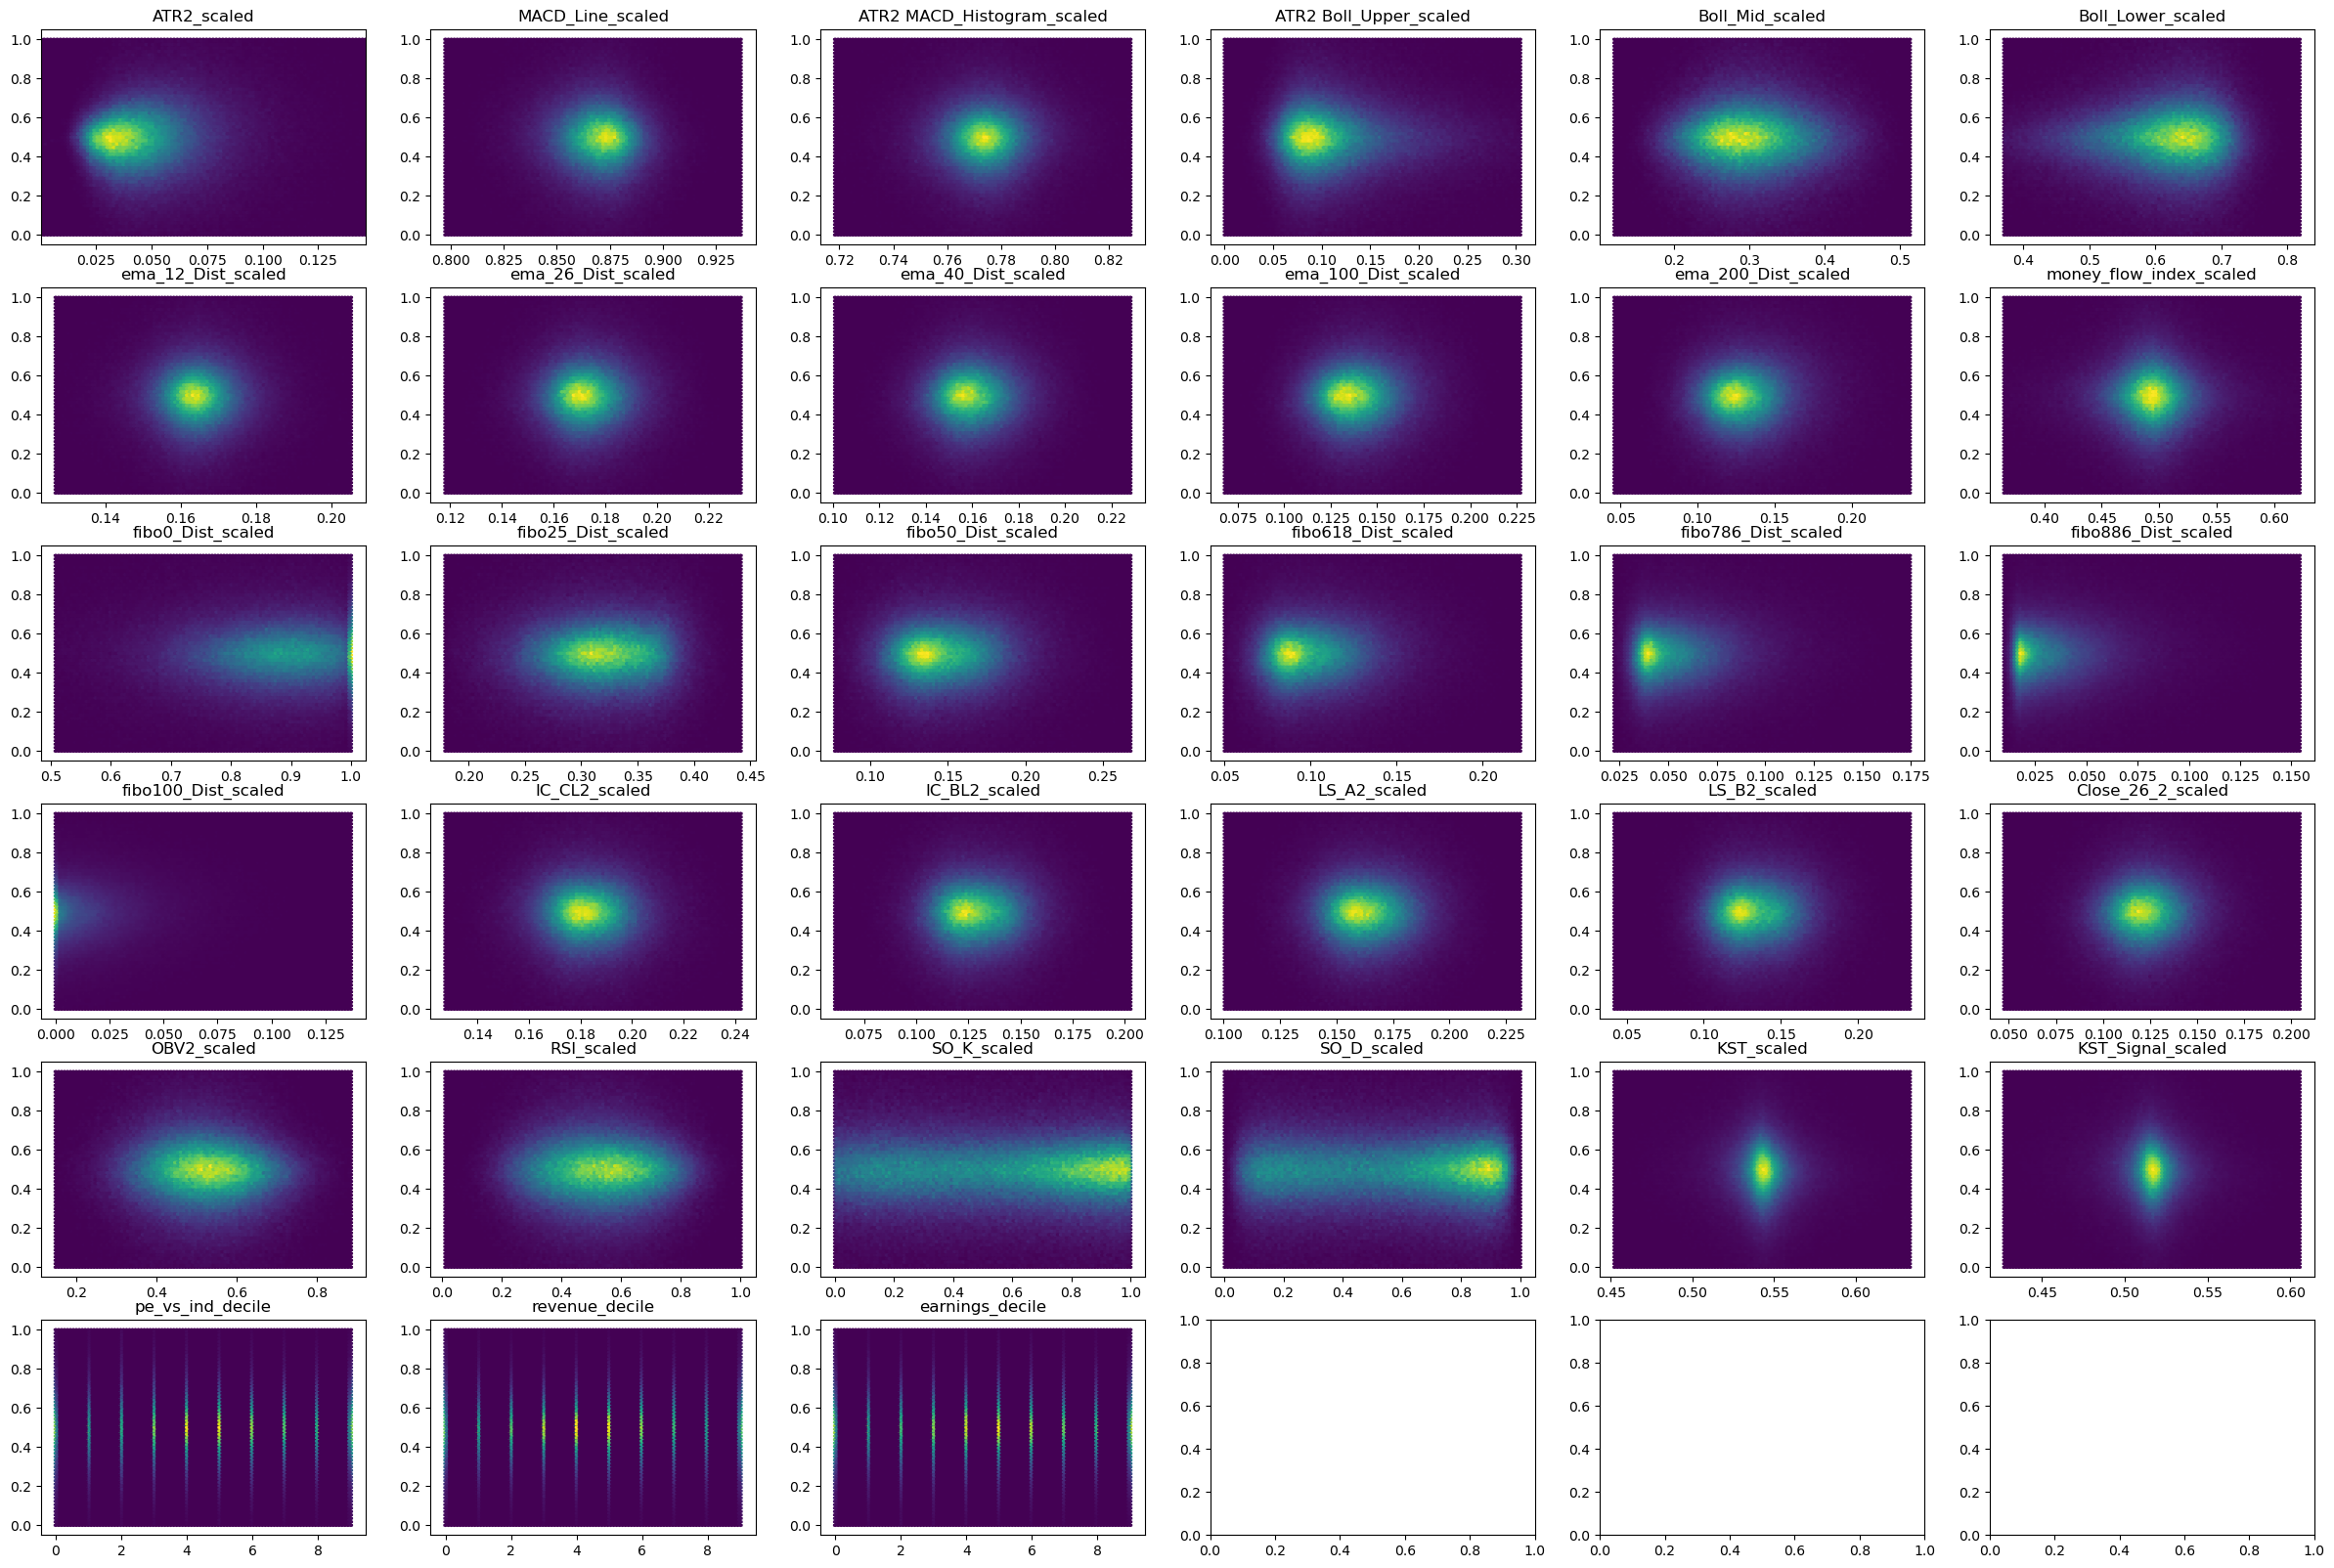

In [80]:
fig, axes = plt.subplots(6,6, figsize=(30,20))
axes[0, 0].hexbin(x=final_data['ATR2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 0].title.set_text('ATR2_scaled')
axes[0, 0].set_xlim([final_data['ATR2_scaled'].min(), final_data['ATR2_scaled'].max()])
axes[0, 1].hexbin(x=final_data['MACD_Line_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 1].title.set_text('MACD_Line_scaled')
axes[0, 2].hexbin(x=final_data['MACD_Histogram_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 2].title.set_text('ATR2 MACD_Histogram_scaled')
axes[0, 3].hexbin(x=final_data['Boll_Upper_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 3].title.set_text('ATR2 Boll_Upper_scaled')
axes[0, 4].hexbin(x=final_data['Boll_Mid_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 4].title.set_text('Boll_Mid_scaled')
axes[0, 5].hexbin(x=final_data['Boll_Lower_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[0, 5].title.set_text('Boll_Lower_scaled')
axes[1, 0].hexbin(x=final_data['ema_12_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 0].title.set_text('ema_12_Dist_scaled')
axes[1, 1].hexbin(x=final_data['ema_26_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 1].title.set_text('ema_26_Dist_scaled')
axes[1, 2].hexbin(x=final_data['ema_40_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 2].title.set_text('ema_40_Dist_scaled')
axes[1, 3].hexbin(x=final_data['ema_100_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 3].title.set_text('ema_100_Dist_scaled')
axes[1, 4].hexbin(x=final_data['ema_200_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 4].title.set_text('ema_200_Dist_scaled')
axes[1, 5].hexbin(x=final_data['money_flow_index_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[1, 5].title.set_text('money_flow_index_scaled')
axes[2, 0].hexbin(x=final_data['fibo0_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 0].title.set_text('fibo0_Dist_scaled')
axes[2, 1].hexbin(x=final_data['fibo25_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 1].title.set_text('fibo25_Dist_scaled')
axes[2, 2].hexbin(x=final_data['fibo50_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 2].title.set_text('fibo50_Dist_scaled')
axes[2, 3].hexbin(x=final_data['fibo618_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 3].title.set_text('fibo618_Dist_scaled')
axes[2, 4].hexbin(x=final_data['fibo786_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 4].title.set_text('fibo786_Dist_scaled')
axes[2, 5].hexbin(x=final_data['fibo886_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[2, 5].title.set_text('fibo886_Dist_scaled')
axes[3, 0].hexbin(x=final_data['fibo100_Dist_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 0].title.set_text('fibo100_Dist_scaled')
axes[3, 1].hexbin(x=final_data['IC_CL2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 1].title.set_text('IC_CL2_scaled')
axes[3, 2].hexbin(x=final_data['IC_BL2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 2].title.set_text('IC_BL2_scaled')
axes[3, 3].hexbin(x=final_data['LS_A2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 3].title.set_text('LS_A2_scaled')
axes[3, 4].hexbin(x=final_data['LS_B2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 4].title.set_text('LS_B2_scaled')
axes[3, 5].hexbin(x=final_data['Close_26_2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[3, 5].title.set_text('Close_26_2_scaled')
axes[4, 0].hexbin(x=final_data['OBV2_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 0].title.set_text('OBV2_scaled')
axes[4, 1].hexbin(x=final_data['RSI_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 1].title.set_text('RSI_scaled')
axes[4, 2].hexbin(x=final_data['SO_K_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 2].title.set_text('SO_K_scaled')
axes[4, 3].hexbin(x=final_data['SO_D_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 3].title.set_text('SO_D_scaled')
axes[4, 4].hexbin(x=final_data['KST_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 4].title.set_text('KST_scaled')
axes[4, 5].hexbin(x=final_data['KST_Signal_scaled'], y=final_data['2_wk_close_pct_scaled'])
axes[4, 5].title.set_text('KST_Signal_scaled')
axes[5, 0].hexbin(x=final_data['pe_vs_ind_decile'], y=final_data['2_wk_close_pct_scaled'])
axes[5, 0].title.set_text('pe_vs_ind_decile')
axes[5, 1].hexbin(x=final_data['revenue_decile'], y=final_data['2_wk_close_pct_scaled'])
axes[5, 1].title.set_text('revenue_decile')
axes[5, 2].hexbin(x=final_data['earnings_decile'], y=final_data['2_wk_close_pct_scaled'])
axes[5, 2].title.set_text('earnings_decile')


#### Not seeing any positive or negative correlation with any distinct variables

## Test/Training Split

In [81]:
final_data.dtypes

2_wk_close_pct_scaled      float64
ATR2_scaled                float64
MACD_Line_scaled           float64
MACD_Signal_scaled         float64
MACD_Histogram_scaled      float64
Boll_Upper_scaled          float64
Boll_Mid_scaled            float64
Boll_Lower_scaled          float64
ema_12_Dist_scaled         float64
ema_26_Dist_scaled         float64
ema_40_Dist_scaled         float64
ema_100_Dist_scaled        float64
ema_200_Dist_scaled        float64
money_flow_index_scaled    float64
fibo0_Dist_scaled          float64
fibo25_Dist_scaled         float64
fibo50_Dist_scaled         float64
fibo618_Dist_scaled        float64
fibo786_Dist_scaled        float64
fibo886_Dist_scaled        float64
fibo100_Dist_scaled        float64
IC_CL2_scaled              float64
IC_BL2_scaled              float64
LS_A2_scaled               float64
LS_B2_scaled               float64
Close_26_2_scaled          float64
OBV2_scaled                float64
RSI_scaled                 float64
SO_K_scaled         

In [82]:
ema_flags = final_data_precursor[['ema_12v26_cross_up_flg', 'ema_12v26_cross_dn_flg', 'ema_26v40_cross_up_flg', 'ema_26v40_cross_dn_flg' \
                      ,'ema_40v100_cross_up_flg', 'ema_40v100_cross_dn_flg', 'ema_100v200_cross_up_flg', 'ema_100v200_cross_dn_flg']]

In [83]:
final_data2 = final_data.merge(ema_flags, left_index=True, right_index=True)

### Lets remove all but 2 standard deviations

In [84]:
final_data3 = final_data2[(final_data2['2_wk_close_pct_scaled'] < (final_data2['2_wk_close_pct_scaled'].mean() + final_data2['2_wk_close_pct_scaled'].std()*2)) & (final_data2['2_wk_close_pct_scaled'] > (final_data2['2_wk_close_pct_scaled'].mean() - final_data2['2_wk_close_pct_scaled'].std()*2)) ]

In [85]:
# Keeping an out of time validation dataset should there be bias due to time

final_data_in = final_data3[final_data3.index.get_level_values(1) < '2023-06-01']
final_data_out = final_data3[final_data3.index.get_level_values(1) >= '2023-06-01']

In [86]:
X_A = final_data_in.drop(columns = ['2_wk_close_pct_scaled'])           

In [87]:
X_A_Out = final_data_out.drop(columns = ['2_wk_close_pct_scaled'])           

In [88]:
Y = final_data_in[['2_wk_close_pct_scaled']]
Y_Out = final_data_out[['2_wk_close_pct_scaled']]

In [89]:
#### Setting up test and train data

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X_A, Y, test_size=0.2, random_state=2)
train, test = train_test_split(final_data_in, test_size=0.2, random_state=2)

In [91]:
final_data_in.dtypes

2_wk_close_pct_scaled       float64
ATR2_scaled                 float64
MACD_Line_scaled            float64
MACD_Signal_scaled          float64
MACD_Histogram_scaled       float64
Boll_Upper_scaled           float64
Boll_Mid_scaled             float64
Boll_Lower_scaled           float64
ema_12_Dist_scaled          float64
ema_26_Dist_scaled          float64
ema_40_Dist_scaled          float64
ema_100_Dist_scaled         float64
ema_200_Dist_scaled         float64
money_flow_index_scaled     float64
fibo0_Dist_scaled           float64
fibo25_Dist_scaled          float64
fibo50_Dist_scaled          float64
fibo618_Dist_scaled         float64
fibo786_Dist_scaled         float64
fibo886_Dist_scaled         float64
fibo100_Dist_scaled         float64
IC_CL2_scaled               float64
IC_BL2_scaled               float64
LS_A2_scaled                float64
LS_B2_scaled                float64
Close_26_2_scaled           float64
OBV2_scaled                 float64
RSI_scaled                  

## Unsupervised Model Builds

### Prepare Data for Unsupervised Model

In [92]:
log_final_data = final_data_precursor.copy()

In [93]:
log_final_data['bin_outcome'] = pd.qcut(log_final_data['2_wk_close_pct'], 10, labels=False).apply(str)

### Transform linear variables to categorical

#### Money Flow Index Ranking

In [94]:
log_final_data['MFI_Rnk'] = pd.qcut(log_final_data['money_flow_index'], 5, 
                               labels = False) 


#### KST Flag

In [95]:
log_final_data['KST_S2_A'] = np.where((log_final_data['KST'] < 0) & (log_final_data['KST'] < log_final_data['KST_Signal']), 1, 0)
log_final_data['KST_S2_B'] = np.where((log_final_data['KST'] < 0) & (log_final_data['KST'] > log_final_data['KST_Signal']), 1, 0)
log_final_data['KST_S2_C'] = np.where((log_final_data['KST'] > 0) & (log_final_data['KST'] < log_final_data['KST_Signal']), 1, 0)
log_final_data['KST_S2_D'] = np.where((log_final_data['KST'] > 0) & (log_final_data['KST'] > log_final_data['KST_Signal']), 1, 0)

#### Bollinger Band Proximity

In [96]:
log_final_data['Boll_Upper_Rnk'] = pd.qcut(log_final_data['Boll_Upper_Dist'], 5, 
                               labels = False) 
log_final_data['Boll_Mid_Rnk'] = pd.qcut(log_final_data['Boll_Mid_Dist'], 5, 
                               labels = False)
log_final_data['Boll_Lower_Rnk'] = pd.qcut(log_final_data['Boll_Lower_Dist'], 5, 
                               labels = False)

#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['Boll_Upper_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['Boll_Mid_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['Boll_Lower_Rnk', ])

#### RSI Location

In [97]:
log_final_data['RSI_Rnk'] = pd.qcut(log_final_data['RSI'], 5, 
                               labels = False)
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['RSI_Rnk', ])

#### MACD Rankings

In [98]:
log_final_data['MACD_Line_Rnk'] = pd.qcut(log_final_data['MACD_Line2'], 5, 
                               labels = False)

log_final_data['MACD_Signal_Rnk'] = pd.qcut(log_final_data['MACD_Signal2'], 5, 
                               labels = False)

log_final_data['MACD_Histogram_Rnk'] = pd.qcut(log_final_data['MACD_Histogram2'], 5, 
                               labels = False)

#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['MACD_Line_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['MACD_Signal_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['MACD_Histogram_Rnk', ])

#### Stochastic Ranking

In [99]:
log_final_data['SO_K_Rnk'] = pd.qcut(log_final_data['SO_K'], 5, 
                               labels = False)

#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['SO_K_Rnk', ])

#### ATR Ranking

In [100]:
log_final_data['ATR2'] = log_final_data['ATR'] / log_final_data['close']
log_final_data['ATR_Rnk'] = pd.qcut(log_final_data['ATR2'], 5, 
                               labels = False)
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['ATR_Rnk', ])

#### FIBO Ranking

In [ ]:
log_final_data['min_fibo'] = log_final_data[['fibo0_Dist','fibo100_Dist','fibo25_Dist','fibo50_Dist','fibo618_Dist','fibo786_Dist','fibo886_Dist']].min(axis=1)

log_final_data['min_fibo_dist2'] = (log_final_data['min_fibo'] / log_final_data['close']) / log_final_data['volatility']

log_final_data['Fibo_Rnk'] = pd.qcut(log_final_data['min_fibo_dist2'], 5, 
                               labels = False)
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['Fibo_Rnk', ])

log_final_data = log_final_data.drop(columns = ['fibo0_Dist','fibo25_Dist', 'fibo50_Dist','fibo618_Dist', \
                                                            'fibo786_Dist','fibo886_Dist','fibo100_Dist','min_fibo','min_fibo_dist2'])

#### Ichimoku Cloud Rankings

In [ ]:

log_final_data['IC_CL_Rnk'] = pd.qcut(log_final_data['IC_CL2'], 5, 
                               labels = False)
log_final_data['IC_BL_Rnk'] = pd.qcut(log_final_data['IC_BL2'], 5, 
                               labels = False)
log_final_data['LS_A_Rnk'] = pd.qcut(log_final_data['LS_A2'], 5, 
                               labels = False)
log_final_data['LS_B_Rnk'] = pd.qcut(log_final_data['LS_B2'], 5, 
                               labels = False)
log_final_data['C26_Rnk'] = pd.qcut(log_final_data['Close_26_2'], 5, 
                               labels = False)

#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['IC_CL_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['IC_BL_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['LS_A_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['LS_B_Rnk', ])
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['C26_Rnk', ])

log_final_data = log_final_data.drop(columns = ['IC_CL2','IC_BL2', 'LS_A2', \
                                                            'LS_B2','Close_26_2'])


#### On-Balance Volume (OBV) Ranking

In [ ]:
log_final_data['OBV_Rnk'] = pd.qcut(log_final_data['OBV2'], 5, 
                               labels = False)
#final_data_precursor = pd.get_dummies(final_data_precursor, columns=['OBV_Rnk', ])
log_final_data = log_final_data.drop(columns = ['OBV2','vol26_avg'])

#### Volatility Ranking

In [104]:
log_final_data['volatility_Rnk'] = pd.qcut(log_final_data['volatility'], 5, 
                               labels = False)

In [105]:
log_final_data2 = log_final_data[['2_wk_close_pct','bin_outcome','MFI_Rnk', 'KST_S2_A', 'KST_S2_B', 'KST_S2_C', 'KST_S2_D','Boll_Upper_Rnk',
                'Boll_Mid_Rnk','Boll_Lower_Rnk','RSI_Rnk','MACD_Line_Rnk','MACD_Signal_Rnk','MACD_Histogram_Rnk',
               'SO_K_Rnk','ATR_Rnk','Fibo_Rnk','IC_CL_Rnk','IC_BL_Rnk','LS_A_Rnk','LS_B_Rnk','C26_Rnk',
               'OBV_Rnk','volatility_Rnk','revenue_decile','earnings_decile','pe_vs_ind_decile',
                'earnings_1wk', 'earnings_2wk', 'earnings_4wk','earnings_8wk', 'Industry','Sector']]

## One Hot encoding

In [106]:
log_final_data3 = pd.get_dummies(log_final_data2, columns = ['MFI_Rnk', 'KST_S2_A', 'KST_S2_B', 'KST_S2_C', 'KST_S2_D','Boll_Upper_Rnk',
                'Boll_Mid_Rnk','Boll_Lower_Rnk','RSI_Rnk','MACD_Line_Rnk','MACD_Signal_Rnk','MACD_Histogram_Rnk',
               'SO_K_Rnk','ATR_Rnk','Fibo_Rnk','IC_CL_Rnk','IC_BL_Rnk','LS_A_Rnk','LS_B_Rnk','C26_Rnk',
               'OBV_Rnk','volatility_Rnk','revenue_decile','earnings_decile','pe_vs_ind_decile', 'Industry','Sector'])

In [107]:
summary = pd.DataFrame()
summary['counts'] = log_final_data[['2_wk_close_pct_scaled','bin_outcome']].groupby('bin_outcome').count()
summary['min'] = log_final_data[['2_wk_close_pct_scaled','bin_outcome']].groupby('bin_outcome').min()
summary['max'] = log_final_data[['2_wk_close_pct_scaled','bin_outcome']].groupby('bin_outcome').max()
summary

counts       min       max
bin_outcome                            
0            134831  0.000000  0.292981
1            134829  0.292983  0.370184
2            134828  0.370184  0.419003
3            134830  0.419004  0.457109
4            134830  0.457109  0.490483
5            134828  0.490484  0.523632
6            134831  0.523633  0.560409
7            134828  0.560409  0.607004
8            134830  0.607004  0.682571
9            134829  0.682571  1.000000

In [108]:
log_final_data_in = log_final_data3[log_final_data3.index.get_level_values(1) < '2023-06-01']
log_final_data_out = log_final_data3[log_final_data3.index.get_level_values(1) >= '2023-06-01']

log_final_data_in = log_final_data_in[log_final_data_in['earnings_8wk'] == 1]
log_final_data_out = log_final_data_out[log_final_data_out['earnings_8wk'] == 1]

In [109]:
x = log_final_data_in.drop(columns = ['bin_outcome','2_wk_close_pct'])
x_out = log_final_data_out.drop(columns = ['bin_outcome','2_wk_close_pct'])
y = log_final_data_in[['bin_outcome','2_wk_close_pct']]
y_out = log_final_data_out[['bin_outcome','2_wk_close_pct']]
X_train, X_test, Y_train, Y_test = train_test_split( x, y, test_size=0.2, random_state=2)
#Y_train2 = Y_train['bin_outcome','2_wk_close_pct']
#Y_test2 = Y_test['bin_outcome','2_wk_close_pct']

In [110]:
x_out

earnings_1wk  earnings_2wk  earnings_4wk  earnings_8wk  \
ticker date2                                                                
A      2023-06-01             0             0             0             1   
NEOG   2023-06-01             1             1             1             1   
A      2023-06-02             0             0             0             1   
NEOG   2023-06-02             1             1             1             1   
A      2023-06-05             0             0             0             1   
...                         ...           ...           ...           ...   
STZ    2023-09-29             0             0             0             1   
       2023-10-02             0             0             0             1   
TAP    2023-10-02             1             1             1             1   
STZ    2023-10-03             0             0             0             1   
TAP    2023-10-03             1             1             1             1   

                   MFI_Rnk_0  MFI_Rnk_1  MFI_Rnk_2  MFI_Rnk_3  MFI_Rnk_4  \
ticker date2                                                               
A      2023-06-01          0          0          0          0          1   
NEOG   2023-06-01          0          0          0          1          0   
A      2023-06-02          0          0          0          0          1   
NEOG   2023-06-02          0          0          0          0          1   
A      2023-06-05          0          0          1          0          0   
...                      ...        ...        ...        ...        ...   
STZ    2023-09-29          1          0          0          0          0   
       2023-10-02          1          0          0          0          0   
TAP    2023-10-02          0          1          0          0          0   
STZ    2023-10-03          0          0          0          1          0   
TAP    2023-10-03          0          1          0          0          0   

                   KST_S2_A_0  ...  Sector_Consumer Cyclical  \
ticker date2                   ...                             
A      2023-06-01           0  ...                         0   
NEOG   2023-06-01           1  ...                         0   
A      2023-06-02           0  ...                         0   
NEOG   2023-06-02           1  ...                         0   
A      2023-06-05           0  ...                         0   
...                       ...  ...                       ...   
STZ    2023-09-29           0  ...                         0   
       2023-10-02           0  ...                         0   
TAP    2023-10-02           1  ...                         0   
STZ    2023-10-03           0  ...                         0   
TAP    2023-10-03           1  ...                         0   

                   Sector_Consumer Defensive  Sector_Energy  \
ticker date2                                                  
A      2023-06-01                          0              0   
NEOG   2023-06-01                          0              0   
A      2023-06-02                          0              0   
NEOG   2023-06-02                          0              0   
A      2023-06-05                          0              0   
...                                      ...            ...   
STZ    2023-09-29                          1              0   
       2023-10-02                          1              0   
TAP    2023-10-02                          1              0   
STZ    2023-10-03                          1              0   
TAP    2023-10-03                          1              0   

                   Sector_Financial Services  Sector_Healthcare  \
ticker date2                                                      
A      2023-06-01                          0                  1   
NEOG   2023-06-01                          0                  1   
A      2023-06-02                          0                  1   
NEOG   2023-06-02                       

## Unsupervised Learning

In [659]:
nnmf_model = NMF(
    n_components=10, 
    init='nndsvda',
    beta_loss='frobenius',
    max_iter=200
          ).fit(X_train)

C:\Users\Eric\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
def label_permute_compare_rating(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
### BEGIN SOLUTION    
    perms = list(permutations(list(range(n))))
    acc=[]
    for i in range(len(perms)):
        mapdict = dict(zip(list(ytdf['bin_outcome'].unique()),list(perms[i])))
        #print(mapdict)
        yt = ytdf['bin_outcome'].apply(lambda x: mapdict[x])
        #if i == 0:
            #print(yt)
        acc.append(accuracy_score(yt,yp))
    idx = np.argmax(acc)    
    return perms[idx], acc[idx]

In [660]:
dist_train = nnmf_model.transform(X_train)
train_pred = dist_train.argmax(axis=1)

(array([  5806.,   7697.,  12381.,  20513.,  11588.,  53717.,  83384.,
         77168., 351248.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

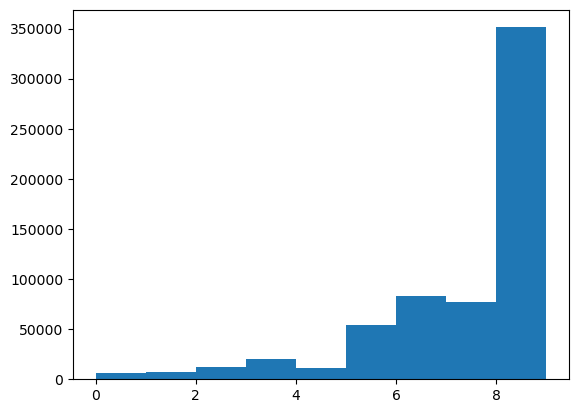

In [661]:
plt.hist(train_pred, bins=9)

labelorder, acc = label_permute_compare_rating(Y_train, train_pred, n = 10)
mapdict = dict(zip(list(Y_train['bin_outcome'].unique()),list(labelorder)))
yt = Y_train['bin_outcome'].apply(lambda x: mapdict[x])
print("accuracy score:", accuracy_score(train_pred, yt))
conf_matrix = confusion_matrix(train_pred, yt)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(mapdict.values()), yticklabels=list(mapdict.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [662]:
train_pred

array([5, 2, 8, ..., 9, 7, 3], dtype=int64)

In [663]:
outcome = Y_train.copy()
outcome['pred_bin'] = train_pred

In [664]:
outcome['bin_outcome_str'] = pd.to_numeric(outcome['bin_outcome'], errors='coerce')

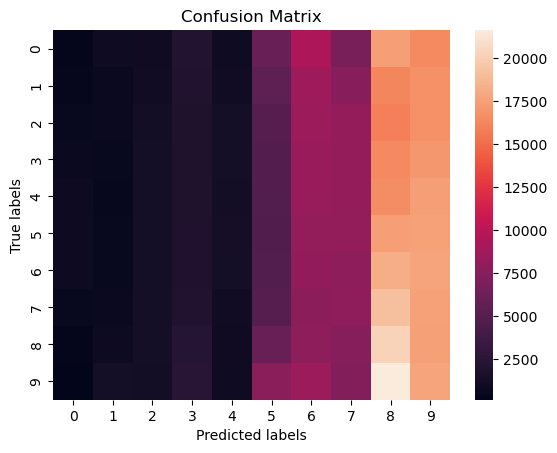

In [665]:
plot_confusion_matrix(outcome['bin_outcome_str'],train_pred)

In [666]:
outcome.groupby('pred_bin')['2_wk_close_pct'].mean()

pred_bin
0    1.001432
1    1.009112
2    1.006774
3    1.007370
4    1.004323
5    1.008905
6    1.002506
7    1.004940
8    1.009285
9    1.006027
Name: 2_wk_close_pct, dtype: float64

In [667]:
dist_test = nnmf_model.transform(X_test)
test_pred = dist_test.argmax(axis=1)

In [668]:
test_pred

array([9, 9, 7, ..., 6, 8, 9], dtype=int64)

In [669]:
outcome_test = Y_test.copy()
outcome_test['pred_bin'] = test_pred

In [670]:
outcome_test.groupby('pred_bin')['2_wk_close_pct'].mean()

pred_bin
0    1.000413
1    1.009316
2    1.005809
3    1.008286
4    1.004729
5    1.008144
6    1.002931
7    1.004892
8    1.009505
9    1.005872
Name: 2_wk_close_pct, dtype: float64

In [671]:
outcome_test['2_wk_close_pct'].mean()

1.0066508517673307

In [672]:
dist_out = nnmf_model.transform(x_out)
out_pred = dist_out.argmax(axis=1)

In [673]:
outcome_out = y_out.copy()
outcome_out['pred_bin'] = out_pred

In [674]:
outcome_out.groupby('pred_bin')['2_wk_close_pct'].mean()

pred_bin
0    0.995283
1    0.997662
2    0.987842
3    0.995240
4    0.988289
5    0.995713
6    0.988651
7    0.994408
8    1.006688
9    0.996151
Name: 2_wk_close_pct, dtype: float64

In [675]:
outcome_out['2_wk_close_pct'].mean()

0.9977322291201353

In [ ]:
X_train

## Jaccard Similarity

    def jacsim(Xr):
  
        n = Xr.shape[1]
        maxr = int(Xr.max())
        
        if maxr>1:
            nz_inter = np.zeros((n,n)).astype(int)
            for i in range(1, maxr+1):
                csr = csr_matrix((Xr==i).astype(int))
                nz_inter = nz_inter + np.array(csr.T.dot(csr).toarray()).astype(int)    
        
        # Convert Xr into a CSR format
        else:
            csr0 = csr_matrix((Xr>0).astype(int))
        
        # Take the dot product
            nz_inter = np.array(csr0.T.dot(csr0).toarray()).astype(int)   
        
        nz_inter = np.nan_to_num(nz_inter,nan = 0)
        # Formula JS:
        A = (Xr>0).astype(bool)
        rowsum = A.sum(axis=0)
        rsumtile = np.repeat(rowsum.reshape((n,1)),n,axis=1)   
        union = rsumtile.T + rsumtile - nz_inter
        
        similarity = (nz_inter / union)
        np.fill_diagonal(similarity, 1)
        #similarity = np.fill_diagonal(similarity, 1)
        #print("union:", union)
        

        
        return similarity

In [552]:
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine
from numpy import dot
from numpy.linalg import norm



In [489]:
## Test if behaviours are sector dependent
x_train_sector = X_train[X_train['Sector_Healthcare'] == 1]
x_out_sector = x_out[x_out['Sector_Healthcare'] == 1]

In [522]:
Y_train_sector = Y_train[Y_train.index.isin(x_train_sector.index)].copy()
Y_out_sector = y_out[y_out.index.isin(x_out_sector.index)].copy()

In [548]:
Y_train_sector = Y_train.copy()
Y_out_sector = y_out.copy()
x_train_sector = X_train.copy()
x_out_sector = x_out.copy()

In [549]:
xtrain_arr = np.array(x_train_sector)
xout_arr = np.array(x_out_sector)

In [589]:
import time
y_test = np.array(Y_train_sector['2_wk_close_pct'])
n = len(xout_arr)
inverval = 100
prediction_v1 = []
prediction_v2 = []
cos_prediction_v1 = []

start = time.time()

for i in range(0,int((n / inverval)) + 1):
    
    if i in(50,100,150,200,250,300,350,400):
        print("i:", i, " time elapsed: ",time.time() - start)
    n_start = inverval * i
    n_end = inverval * (i + 1)

    xout_arr2 = xout_arr[n_start:n_end]

    csr0 = csr_matrix((xout_arr2>0).astype(int))
    csr1 = csr_matrix((xtrain_arr>0).astype(int))

    #numerator = csr0.dot(csr1.T).toarray()
    numerator = csr0.dot(csr1.T)
    ones = np.ones(csr1.shape[::-1])
    ones2 = np.ones(csr0.shape[::-1])
    B = csr1.dot(ones2)
    C = csr0.dot(ones)
    denominator = B.T + C - numerator

    j_test = (numerator / (denominator))
    j_test_power = np.power(j_test, 7)
    
    #cos_sim = dot(B, C)/(norm(B)*norm(C))
    #cos_sim_power = np.power(cos_sim, 7)
    
    ##Weighted average, weights are taken to the 3rd power
    pred_temp_v1 = np.sum(j_test_power * y_test.reshape(len(y_test),1), axis=1) / np.sum(j_test_power, axis=1)
    prediction_v1 = prediction_v1 + np.array(pred_temp_v1).reshape(1,len(pred_temp_v1))[0].tolist()
    
    #cos_temp_v1 = np.sum(cos_sim_power * y_test.reshape(len(y_test),1), axis=1) / np.sum(cos_sim_power, axis=1)
    #cos_prediction_v1 = cos_prediction_v1 + np.array(cos_temp_v1).reshape(1,len(cos_temp_v1))[0].tolist()
    
    
    #prediction_v1.append(pred_temp_v1)
    
    ##Outcome of best match
    pred_temp_v2 = y_test[np.argmax(np.array(j_test), axis = 1)]
    prediction_v2 = prediction_v2 + np.array(pred_temp_v2).reshape(1,len(pred_temp_v2))[0].tolist()
    #prediction_v2.append(pred_temp_v2)

i: 50  time elapsed:  487.4305443763733
i: 100  time elapsed:  973.5960121154785
i: 150  time elapsed:  1451.6087203025818
i: 200  time elapsed:  1926.395709514618
i: 250  time elapsed:  2402.423314332962
i: 300  time elapsed:  2877.8140642642975


In [590]:
y_jac = Y_out_sector.copy()

In [591]:
len(y_jac)

34912

In [592]:
y_jac['prediction_v1'] = prediction_v1
y_jac['prediction_v2'] = prediction_v2

In [599]:
y_jac['pred_v1_bin'] = pd.qcut(y_jac['prediction_v1'], 20, labels=False)
y_jac['pred_v2_bin'] = pd.qcut(y_jac['prediction_v2'], 20, labels=False)

In [600]:
y_jac['prediction_v1'].max()

1.0269224832097632

In [605]:
y_jac['2_wk_close_pct'].mean()

0.9977322291201353

In [604]:
y_jac.groupby('pred_v1_bin')['2_wk_close_pct'].mean()

pred_v1_bin
0     0.992436
1     0.990329
2     0.994087
3     0.995230
4     0.997090
5     0.997467
6     0.996522
7     0.998402
8     0.996542
9     0.997995
10    1.000150
11    1.000841
12    0.998597
13    1.002261
14    1.000159
15    1.000327
16    0.998757
17    0.996407
18    0.998781
19    1.002265
Name: 2_wk_close_pct, dtype: float64

In [603]:
y_jac.groupby('pred_v2_bin')['2_wk_close_pct'].mean()

pred_v2_bin
0     0.994011
1     0.995780
2     0.995283
3     1.000126
4     0.998022
5     0.995425
6     0.999222
7     0.996830
8     0.997109
9     0.997187
10    0.997930
11    0.999654
12    0.998735
13    0.997231
14    1.000238
15    0.996464
16    0.999723
17    0.998314
18    0.999254
19    0.998107
Name: 2_wk_close_pct, dtype: float64

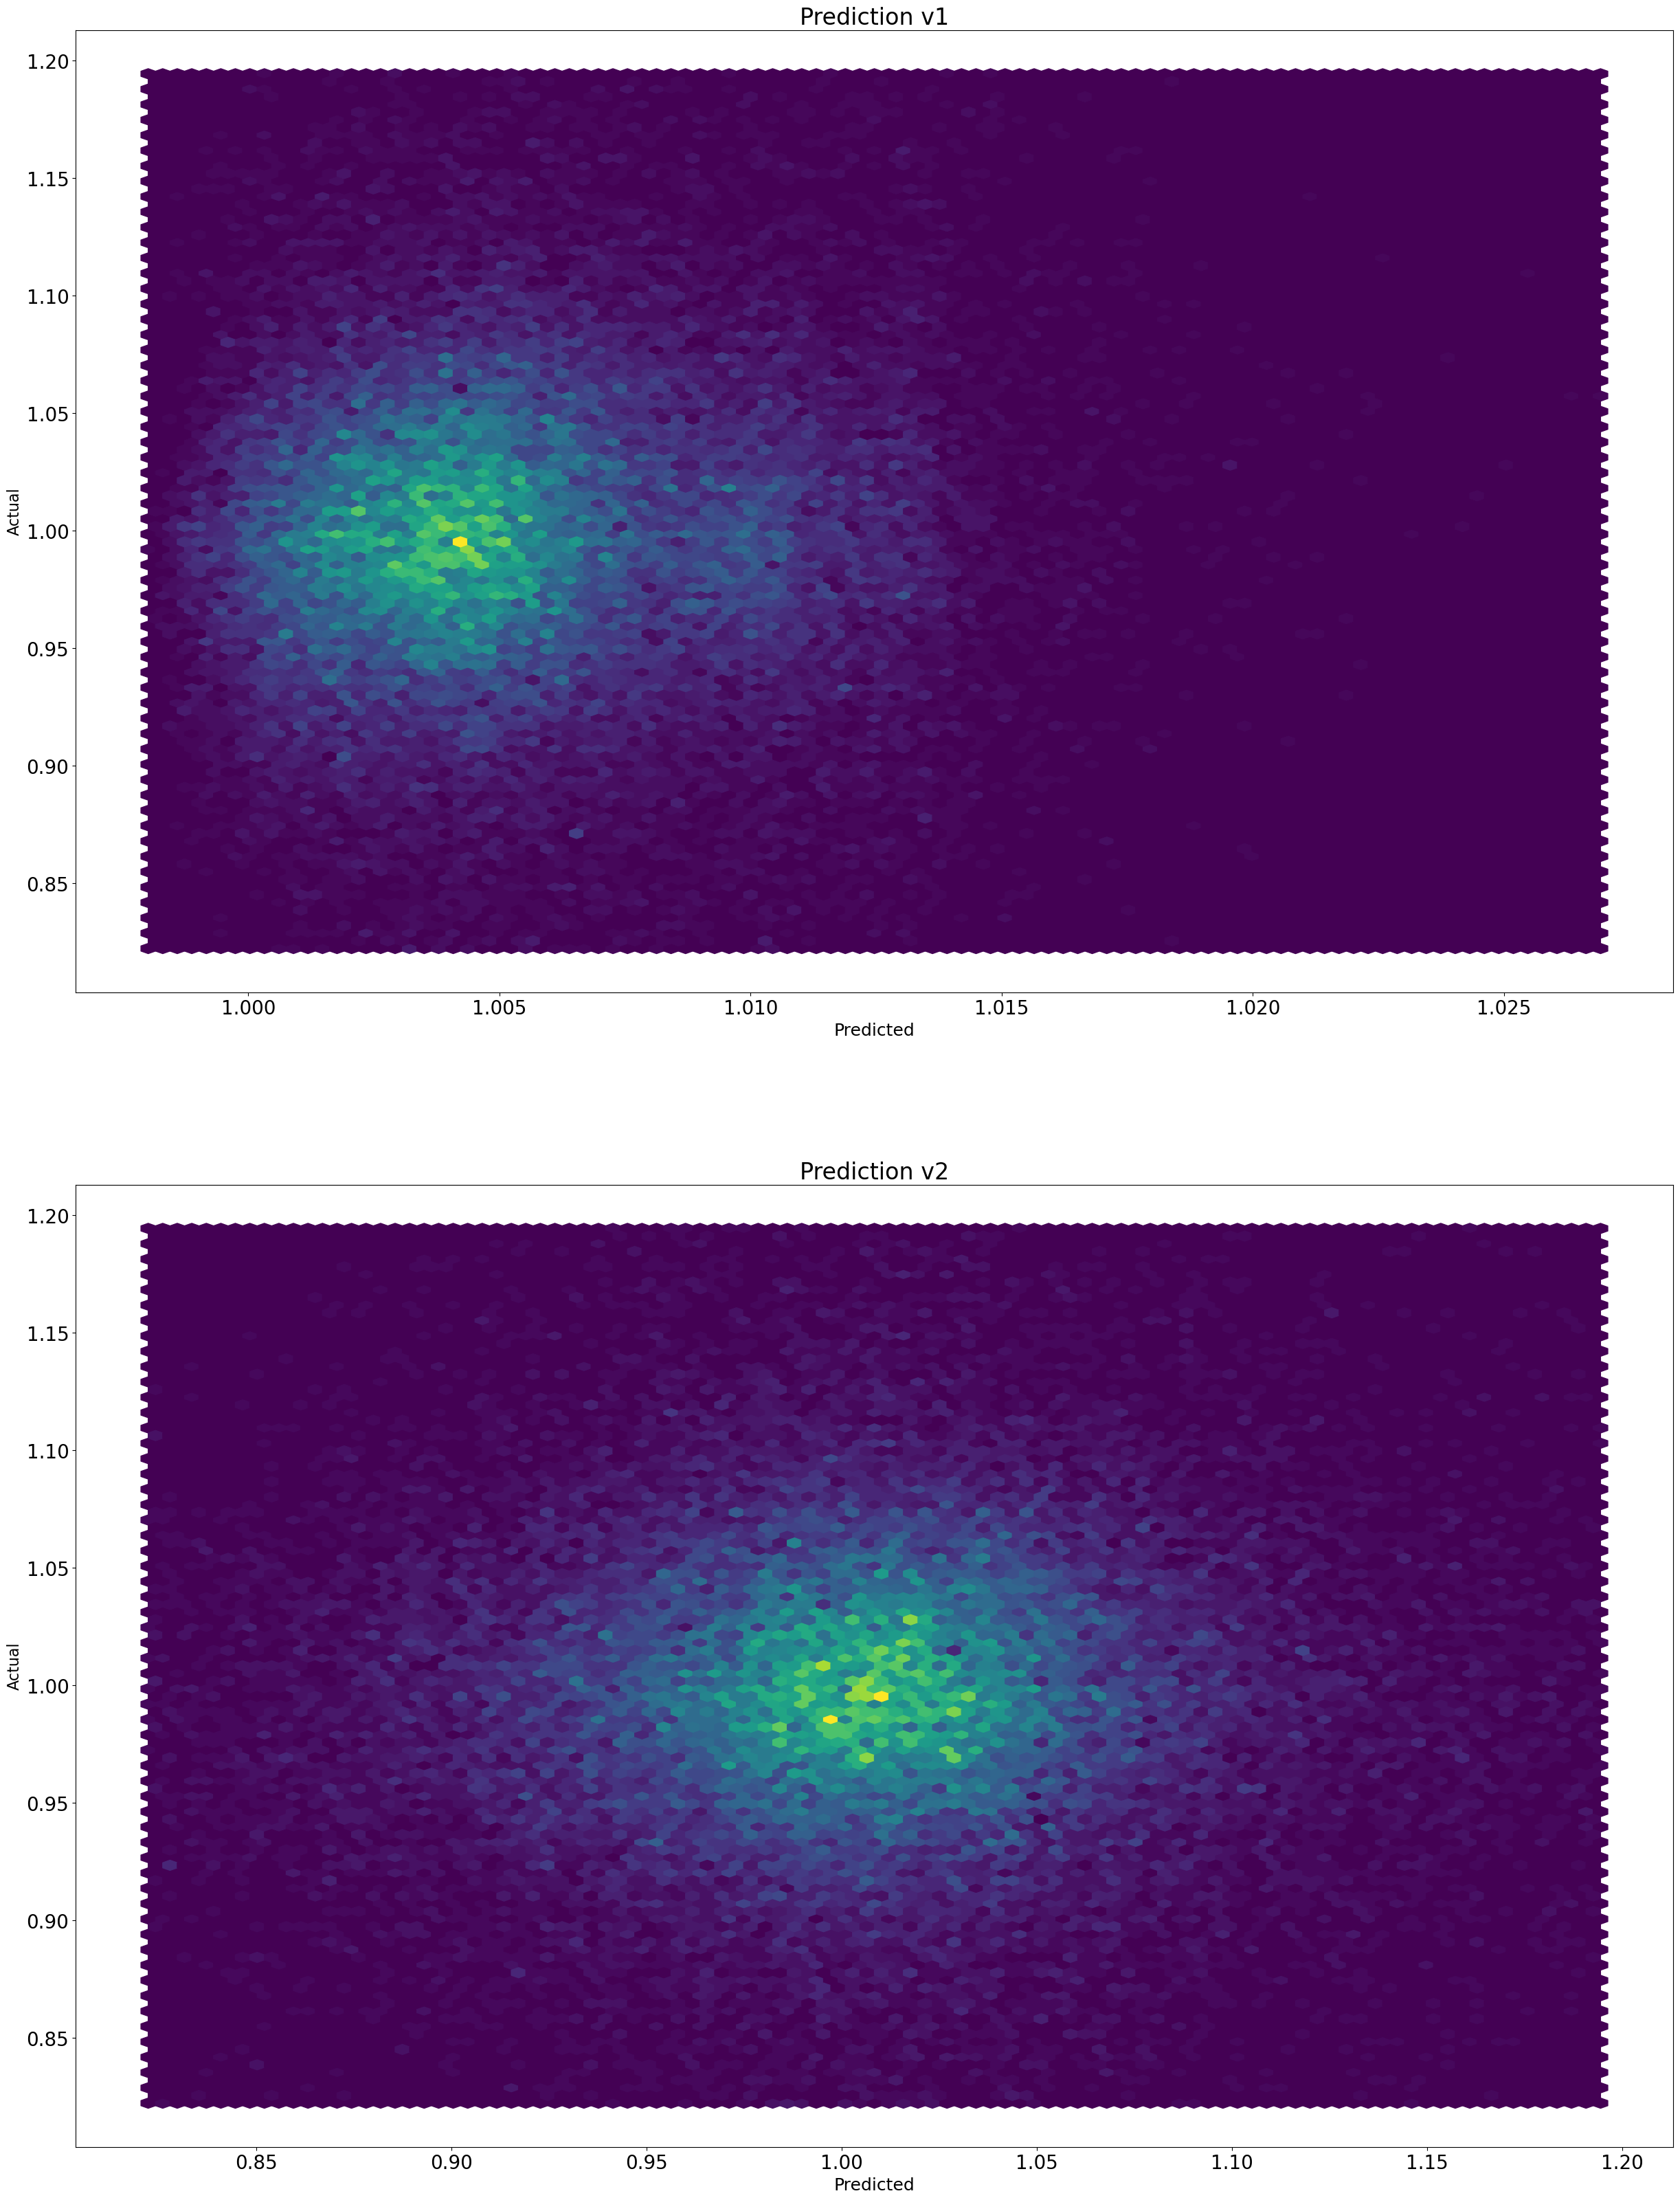

In [658]:
fig, axes = plt.subplots(2,1, figsize=(30,40))

axes[0].hexbin(x=y_jac['prediction_v1'], y=y_jac['2_wk_close_pct'])
axes[0].set_title(label= 'Prediction v1', fontsize = 24)
axes[0].set_xlabel('Predicted', fontsize=18)
axes[0].set_ylabel('Actual', fontsize=16)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[1].hexbin(x=y_jac['prediction_v2'], y=y_jac['2_wk_close_pct'])

axes[1].set_title(label= 'Prediction v2', fontsize = 24)
axes[1].set_xlabel('Predicted', fontsize=18)
axes[1].set_ylabel('Actual', fontsize=16)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)

In [623]:

score_threshold = .9993
print('Mean_Outcome: ',y_jac['2_wk_close_pct'].mean())
print('Lower Score Mean_Outcome: ', y_jac[y_jac['prediction_v1'] < score_threshold]['2_wk_close_pct'].mean())
print('% of records with low score: ', len(y_jac[y_jac['prediction_v1'] < score_threshold]) / len(y_jac))

Mean_Outcome:  0.9977322291201353
Lower Score Mean_Outcome:  0.9869492170176348
% of records with low score:  0.011686526122823098


In [616]:

score_threshold = 1.015
print('Mean_Outcome: ',y_jac['2_wk_close_pct'].mean())
print('Higher Score Mean_Outcome: ', y_jac[y_jac['prediction_v1'] > score_threshold]['2_wk_close_pct'].mean())
print('% of records with high score: ', len(y_jac[y_jac['prediction_v1'] > score_threshold]) / len(y_jac))

Mean_Outcome:  0.9977322291201353
Higher Score Mean_Outcome:  1.0057306797655794
% of records with high score:  0.010827222731439047


In [629]:

score_threshold = .86
print('Mean_Outcome: ',y_jac['2_wk_close_pct'].mean())
print('Lower Score Mean_Outcome: ', y_jac[y_jac['prediction_v2'] < score_threshold]['2_wk_close_pct'].mean())
print('% of records with low score: ', len(y_jac[y_jac['prediction_v2'] < score_threshold]) / len(y_jac))

Mean_Outcome:  0.9977322291201353
Lower Score Mean_Outcome:  0.9876955360377019
% of records with low score:  0.011342804766269478


In [634]:

score_threshold = 1.16
print('Mean_Outcome: ',y_jac['2_wk_close_pct'].mean())
print('Higher Score Mean_Outcome: ', y_jac[y_jac['prediction_v2'] > score_threshold]['2_wk_close_pct'].mean())
print('% of records with high score: ', len(y_jac[y_jac['prediction_v2'] > score_threshold]) / len(y_jac))

Mean_Outcome:  0.9977322291201353
Higher Score Mean_Outcome:  0.9975494954207011
% of records with high score:  0.010397571035747021


#### In conclusion, and this does not come as a particular surprise, but it is extremely difficult to forcast with a level of accuracy how stocks will perform over time.  Variables were initially chosen based on research of popular technical and fundamental indicators.  A test/train split was created, along with a separate out of time validation set which is generally appropriate for most time-series type models as they can be events which create bias which will not show in an in-time validation.  From there, after review of the histograms and coolinearity, outliers were removed and the variables rescaled.  

#### An NMF model was attempted but it provided little value over random selection.  Subsequently, Jaccard similarity was used to determine if stocks which were had similar characteristics would behave similarly.  This is executed by taking the weighted average of the result multiplied by the similarity.  Because the dataset is very large at several hundred thousand records, the value of similarity became somewhat diluted.  So, a high power of similarity was used to reduce that effect.  With so many records comparisons, there are many records with very low similarity, so 5 0.1 records would have the same weight as 1 0.5 record.  Taking similarity to the power of 7, it now takes 78,000 0.1 records to be the equivalent of 1 0.5 record.  This has the effect of weighting more similar records much more heavily, and reducing the dilution effect of many dissimilar records.

#### While generally neither model provided significant forecasting power, on the fringes there is slight correllation with the jaccard method.  The highest and lowest predictions yielded 1% lift and 1% reduction, respectively.  While this is a good outcome, it is a similar outcome to the multivar linear model, while being much more computationally expensive.  